In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+100+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 3.6258033206091707
(0, 1)
(1, 6)
(6, 7)
(7, 12)
(12, 17)
(17, 18)
(18, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 988.05it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 643.68it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 777.60it/s]


In [6]:
# get training and test data set without costs
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols)

Obtaining constraints for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 635.67it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-0.5, num_epochs+0.5)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 2), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 10
log_step = 1

In [11]:
import copy
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                # restore best model
                reg.load_state_dict(best_model_state)
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                   format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### 2-Stage 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from torch import nn
# init loss
mse = nn.MSELoss()

def forward2S(data, reg, loss_func, grad_log):
    # unzip data
    x, c, w, z = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, c)
    return loss

In [14]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forward2S, mse, lr, num_epochs, log_step,
                                                              loader_train_cost, loader_val, loader_test)

  0%|                                                                                           | 0/10 [00:02<?, ?it/s]

Epoch   0, Train Regret:  61.9579%, Val Regret:  66.5088%


Epoch    0, Loss:   0.5669:  10%|█████▌                                                 | 1/10 [00:05<00:34,  3.81s/it]

Epoch   1, Train Regret:  33.7147%, Val Regret:  38.3390%


Epoch    1, Loss:   0.4282:  20%|███████████                                            | 2/10 [00:08<00:25,  3.22s/it]

Epoch   2, Train Regret:  16.8399%, Val Regret:  18.2600%


Epoch    2, Loss:   0.1096:  30%|████████████████▌                                      | 3/10 [00:11<00:21,  3.12s/it]

Epoch   3, Train Regret:  10.6229%, Val Regret:  11.0463%


Epoch    3, Loss:   0.1251:  40%|██████████████████████                                 | 4/10 [00:13<00:17,  3.00s/it]

Epoch   4, Train Regret:   8.5983%, Val Regret:   8.0452%


Epoch    4, Loss:   0.0531:  50%|███████████████████████████▌                           | 5/10 [00:16<00:14,  2.88s/it]

Epoch   5, Train Regret:   7.6684%, Val Regret:   7.9813%


Epoch    5, Loss:   0.1983:  60%|█████████████████████████████████                      | 6/10 [00:19<00:11,  2.85s/it]

Epoch   6, Train Regret:   7.7612%, Val Regret:   7.8837%


Epoch    6, Loss:   0.1061:  70%|██████████████████████████████████████▌                | 7/10 [00:22<00:08,  2.76s/it]

Epoch   7, Train Regret:   7.9067%, Val Regret:   7.8011%


Epoch    7, Loss:   0.0589:  80%|████████████████████████████████████████████           | 8/10 [00:24<00:05,  2.72s/it]

Epoch   8, Train Regret:   7.7140%, Val Regret:   8.0460%


Epoch    8, Loss:   0.3751:  90%|█████████████████████████████████████████████████▌     | 9/10 [00:27<00:02,  2.70s/it]

Epoch   9, Train Regret:   7.7533%, Val Regret:   7.7828%


Epoch    9, Loss:   0.1208: 100%|██████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.84s/it]


Epoch   9, Train Regret:   7.8694%, Val Regret:   8.2066%

Evaluation:
Test Regret: 8.6085%
Training Elapsed Time: 1.55 Sec


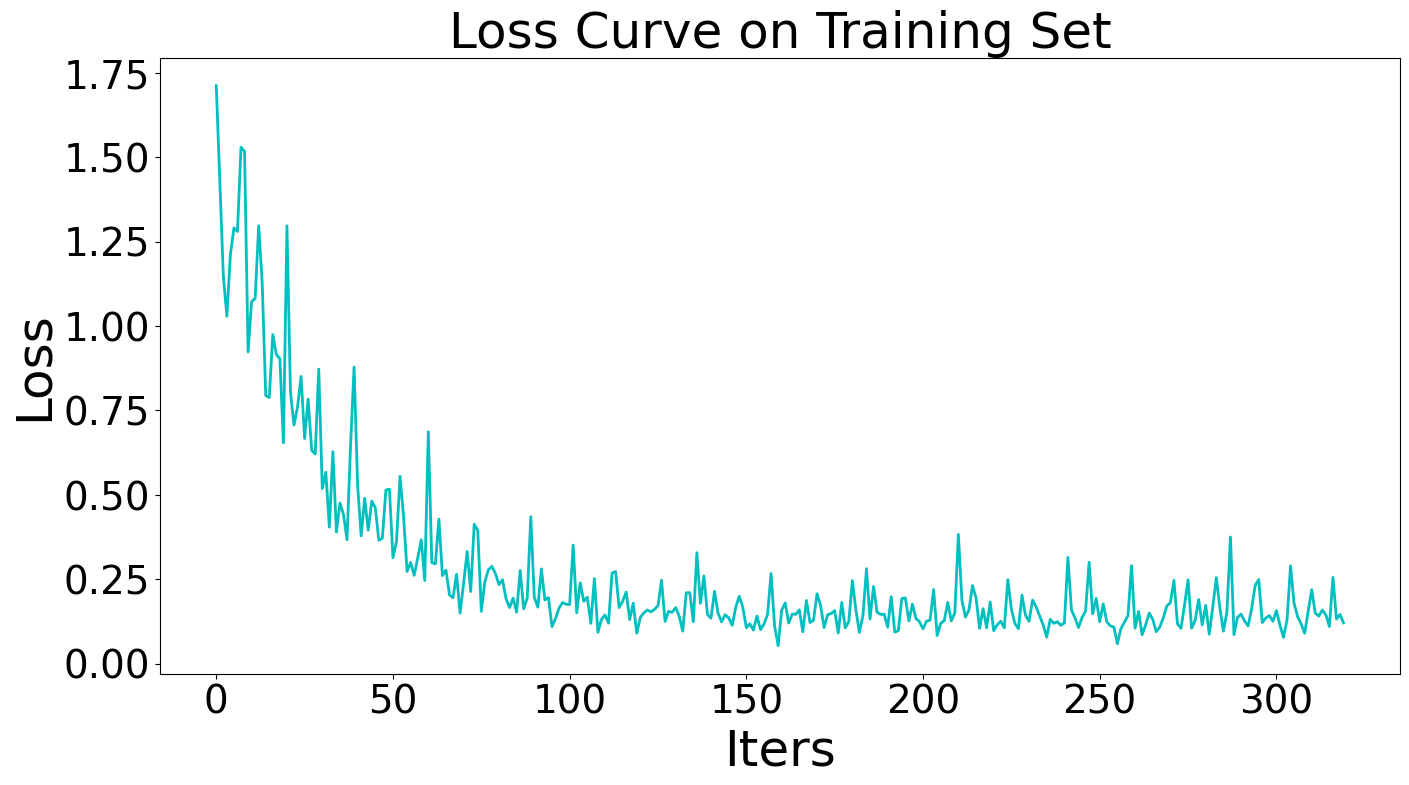

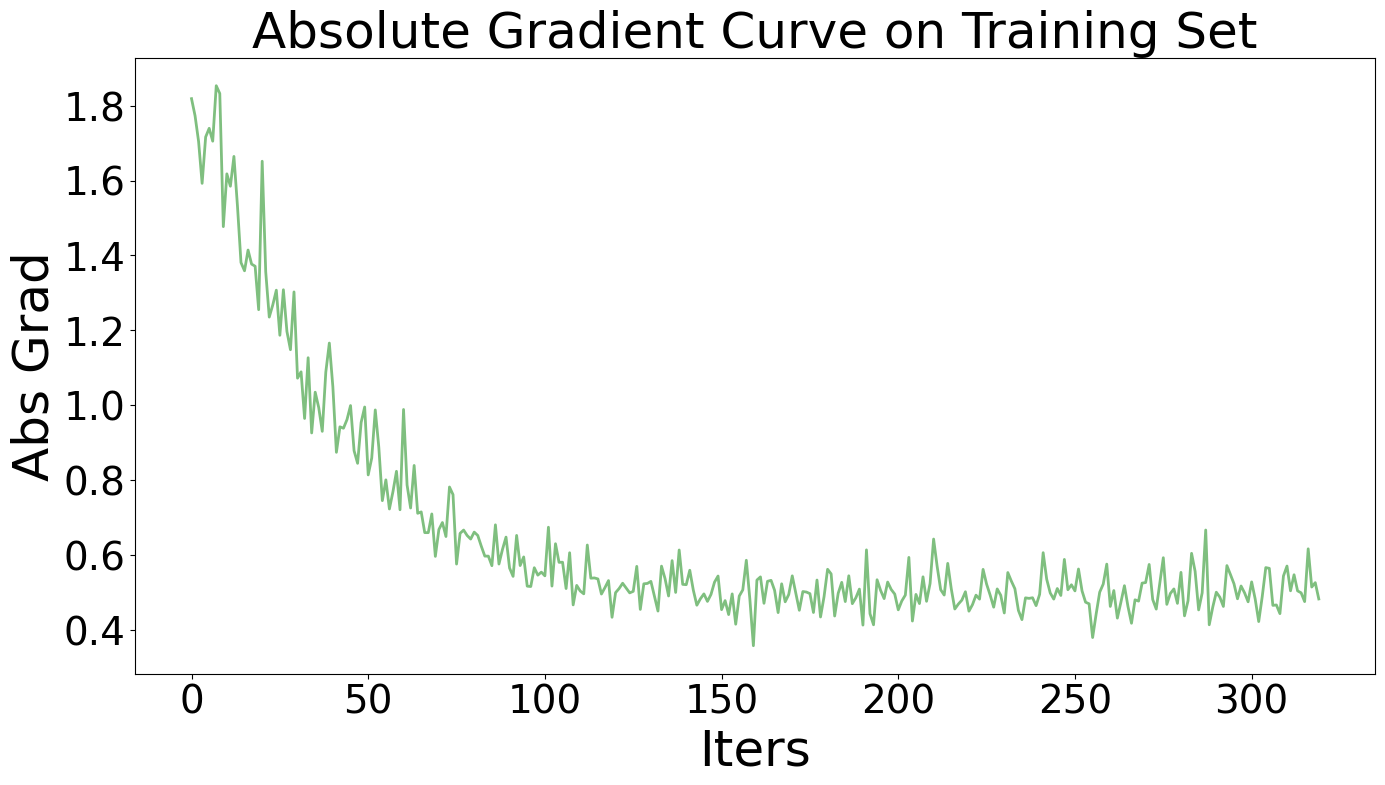

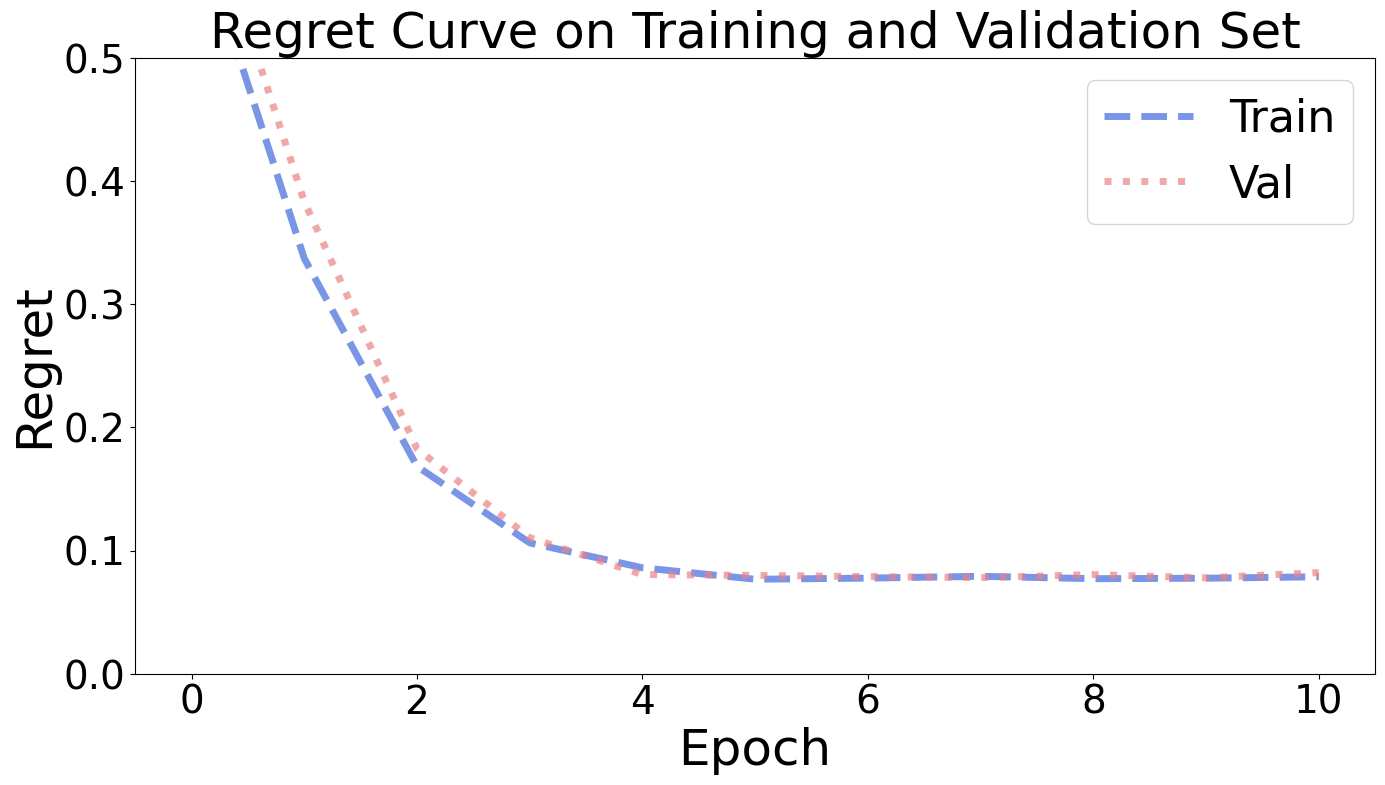

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

(CVXPY) Dec 01 12:33:10 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 8


In [18]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  60.5412%, Val Regret:  64.2153%


Epoch    0, Loss:  -0.9993:  10%|█████▌                                                 | 1/10 [00:13<01:48, 12.00s/it]

Epoch   1, Train Regret:   9.1314%, Val Regret:   7.4276%


Epoch    1, Loss:  -0.9989:  20%|███████████                                            | 2/10 [00:18<01:02,  7.76s/it]

Epoch   2, Train Regret:   9.5749%, Val Regret:   9.8630%


Epoch    2, Loss:  -0.9999:  30%|████████████████▌                                      | 3/10 [00:23<00:44,  6.41s/it]

Epoch   3, Train Regret:   9.3938%, Val Regret:   9.6013%


Epoch    3, Loss:  -0.9999:  40%|██████████████████████                                 | 4/10 [00:28<00:42,  7.11s/it]


Epoch   4, Train Regret:   9.8601%, Val Regret:   8.7421%

Early Stop!

Evaluation:
Test Regret: 9.4337%
Training Elapsed Time: 16.04 Sec


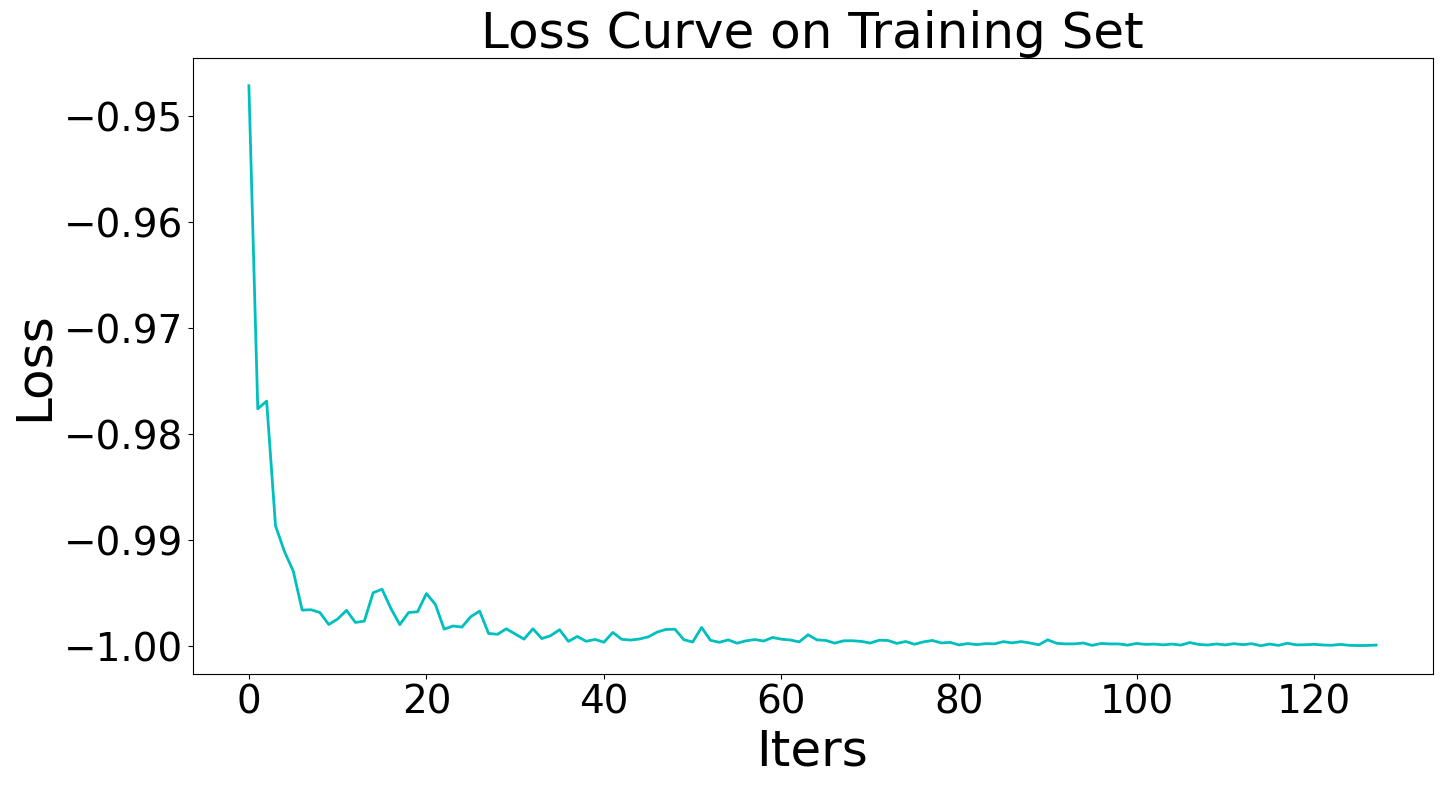

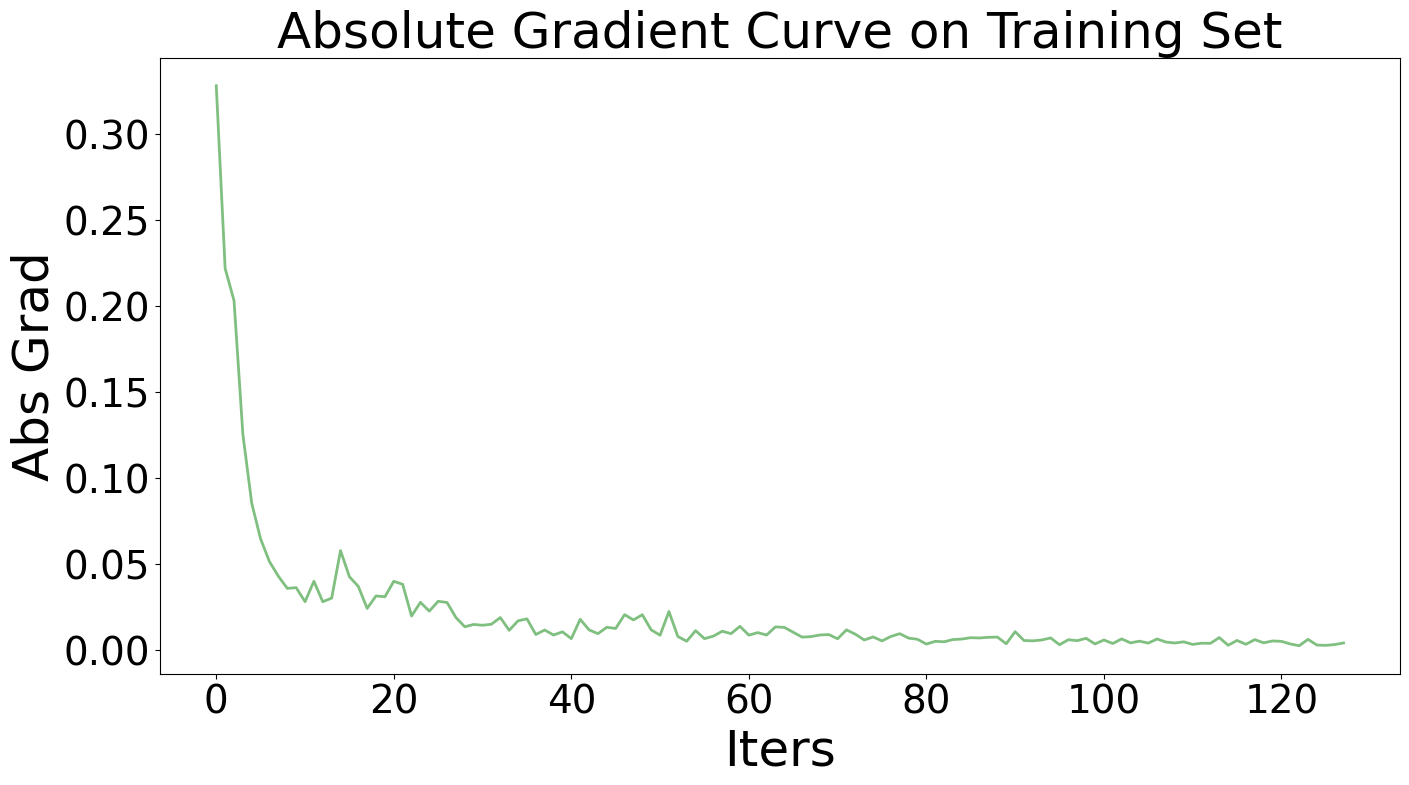

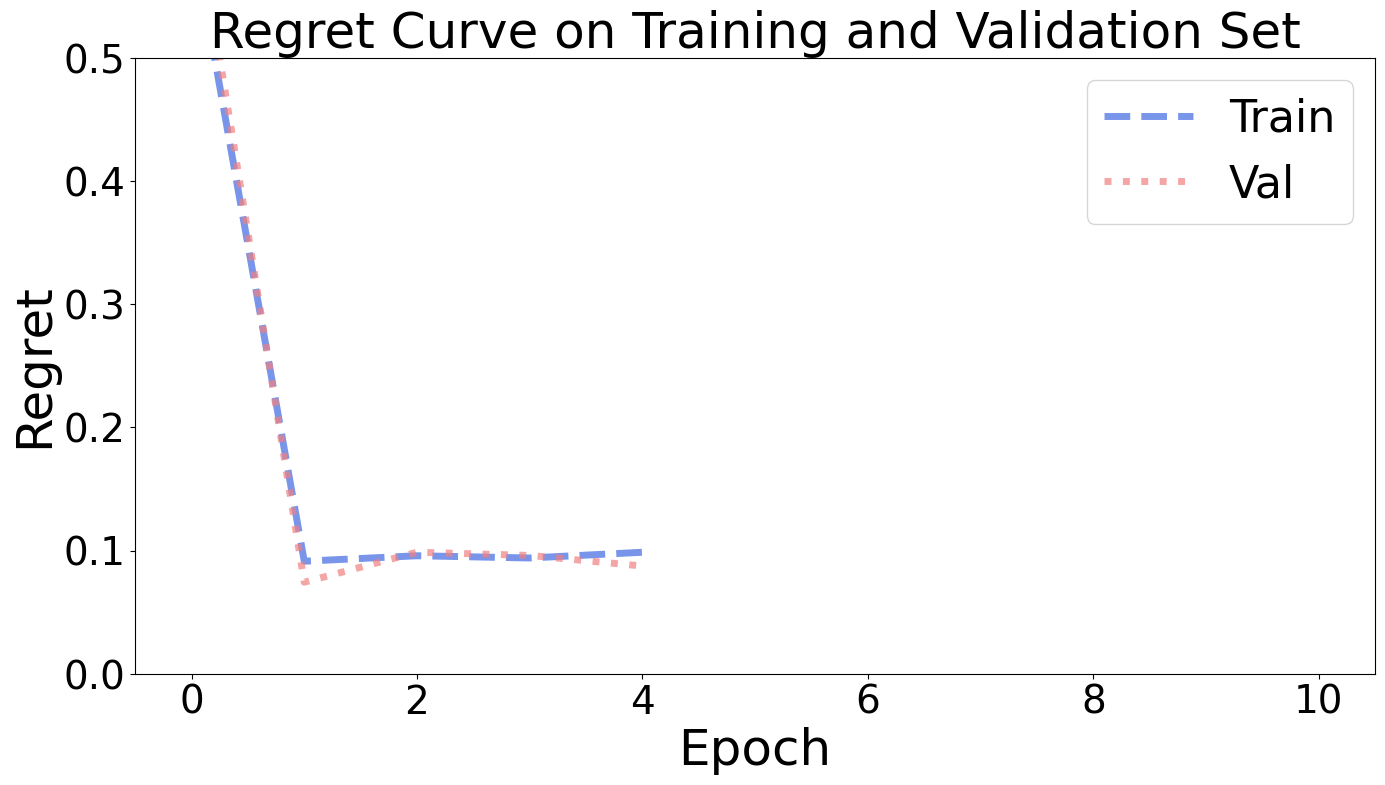

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with NNLS

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="nnls", processes=1)

Num of cores: 1


In [22]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  71.2160%, Val Regret:  73.2458%


Epoch    0, Loss:  -0.9989:  10%|█████▌                                                 | 1/10 [00:05<00:30,  3.35s/it]

Epoch   1, Train Regret:  10.2044%, Val Regret:   9.2434%


Epoch    1, Loss:  -0.9991:  20%|███████████                                            | 2/10 [00:08<00:27,  3.38s/it]

Epoch   2, Train Regret:   8.8780%, Val Regret:  10.0802%


Epoch    2, Loss:  -1.0000:  30%|████████████████▌                                      | 3/10 [00:11<00:22,  3.23s/it]

Epoch   3, Train Regret:   9.5535%, Val Regret:  11.3339%


Epoch    3, Loss:  -0.9999:  40%|██████████████████████                                 | 4/10 [00:14<00:21,  3.61s/it]


Epoch   4, Train Regret:   9.6388%, Val Regret:  14.6429%

Early Stop!

Evaluation:
Test Regret: 11.8804%
Training Elapsed Time: 1.65 Sec


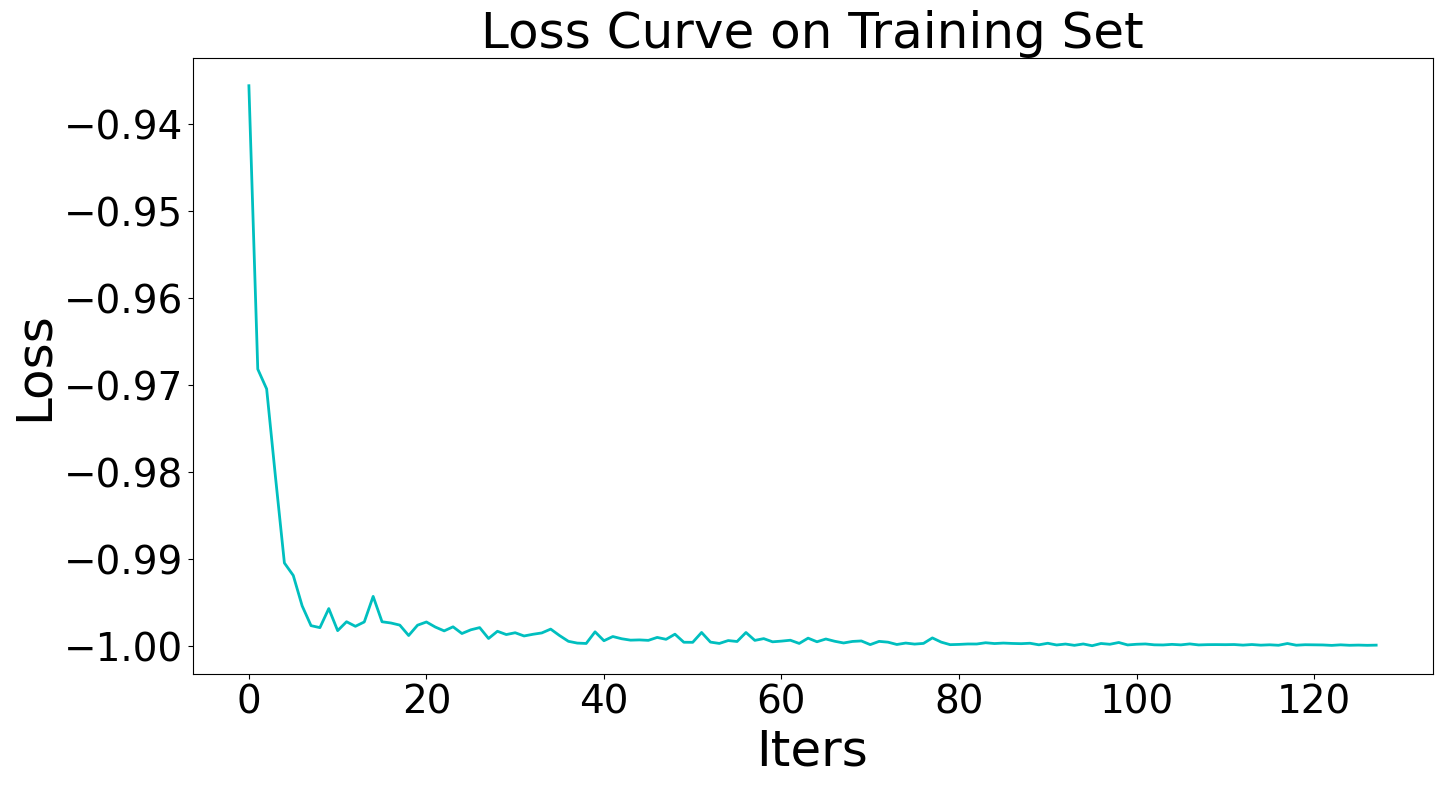

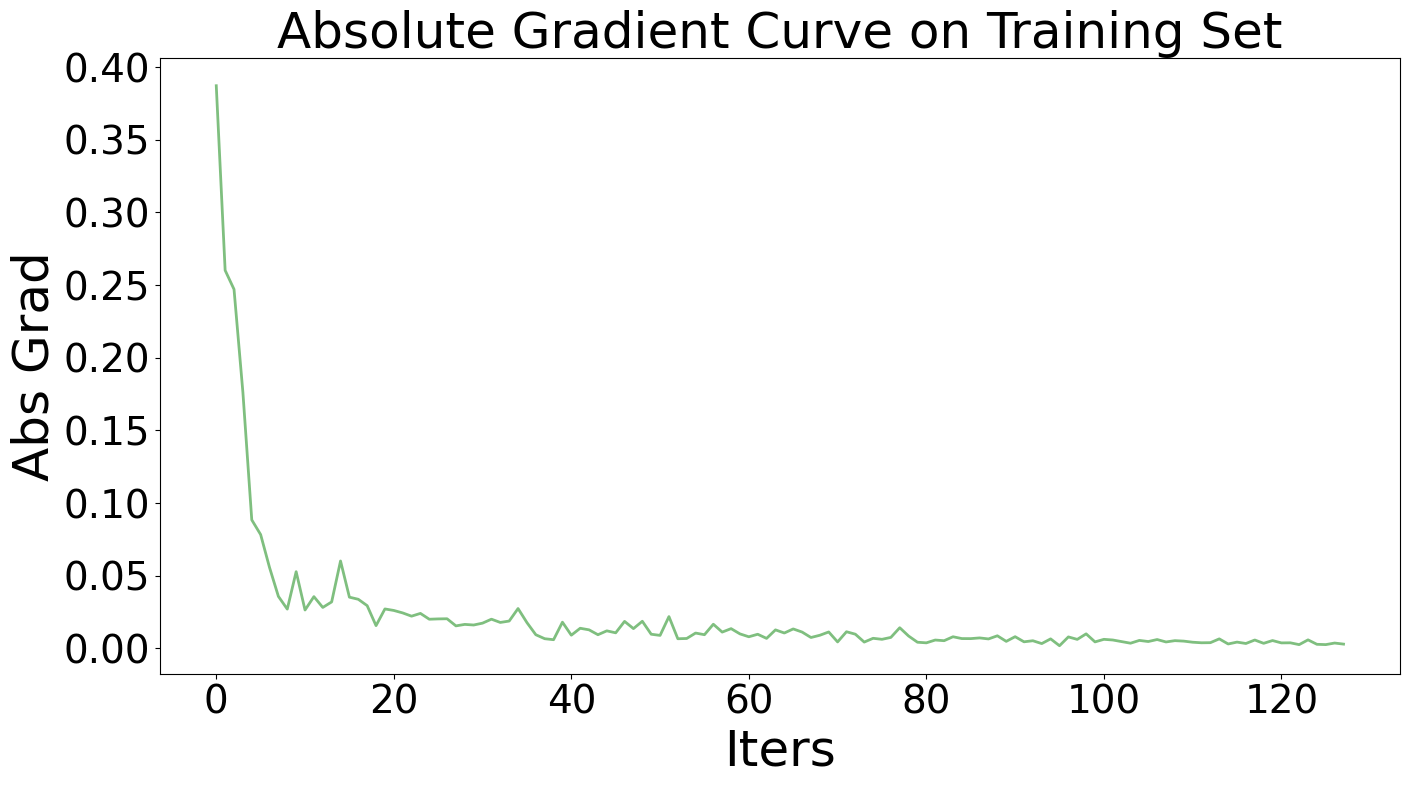

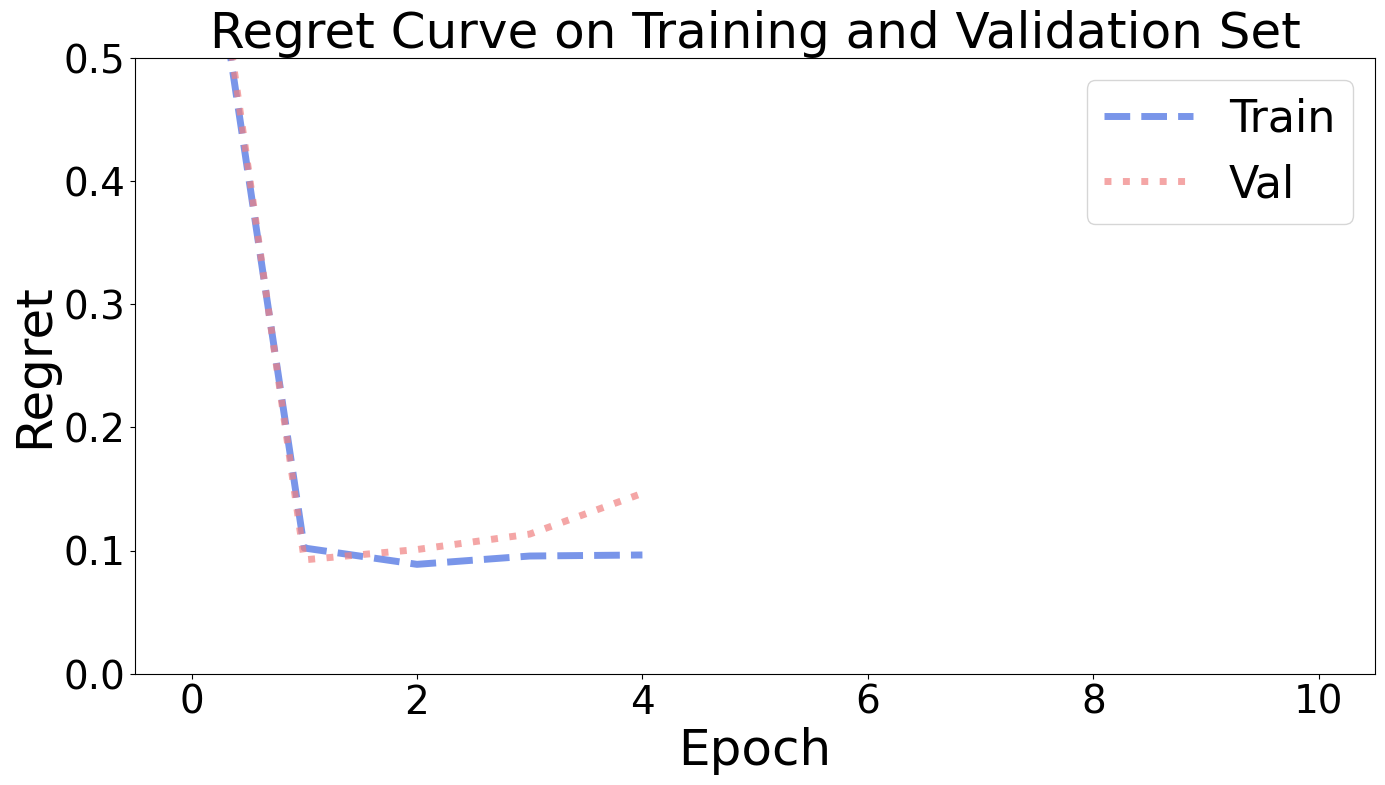

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

Num of cores: 1


In [26]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  71.2160%, Val Regret:  73.2458%


Epoch    0, Loss:  -0.5432:  10%|█████▌                                                 | 1/10 [00:04<00:24,  2.75s/it]

Epoch   1, Train Regret:  26.5759%, Val Regret:  30.0409%


Epoch    1, Loss:  -0.6792:  20%|███████████                                            | 2/10 [00:06<00:21,  2.73s/it]

Epoch   2, Train Regret:  10.8260%, Val Regret:  10.7152%


Epoch    2, Loss:  -0.7347:  30%|████████████████▌                                      | 3/10 [00:09<00:18,  2.67s/it]

Epoch   3, Train Regret:   8.9626%, Val Regret:   9.0878%


Epoch    3, Loss:  -0.7458:  40%|██████████████████████                                 | 4/10 [00:12<00:16,  2.72s/it]

Epoch   4, Train Regret:   8.7656%, Val Regret:   9.6280%


Epoch    4, Loss:  -0.7293:  50%|███████████████████████████▌                           | 5/10 [00:15<00:13,  2.75s/it]

Epoch   5, Train Regret:   8.9144%, Val Regret:   9.8213%


Epoch    5, Loss:  -0.7545:  60%|█████████████████████████████████                      | 6/10 [00:18<00:12,  3.02s/it]


Epoch   6, Train Regret:   8.7554%, Val Regret:  11.2439%

Early Stop!

Evaluation:
Test Regret: 9.2068%
Training Elapsed Time: 1.22 Sec


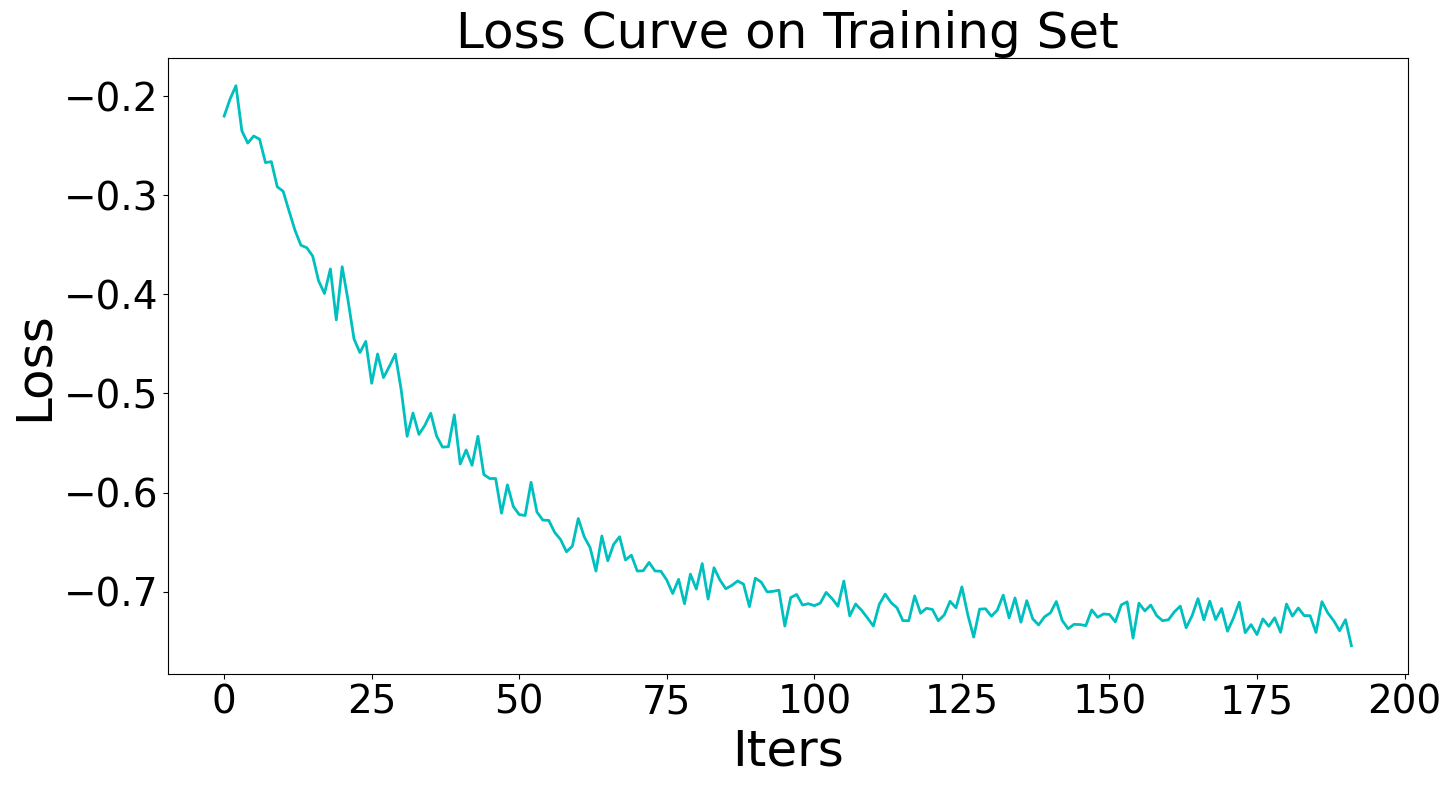

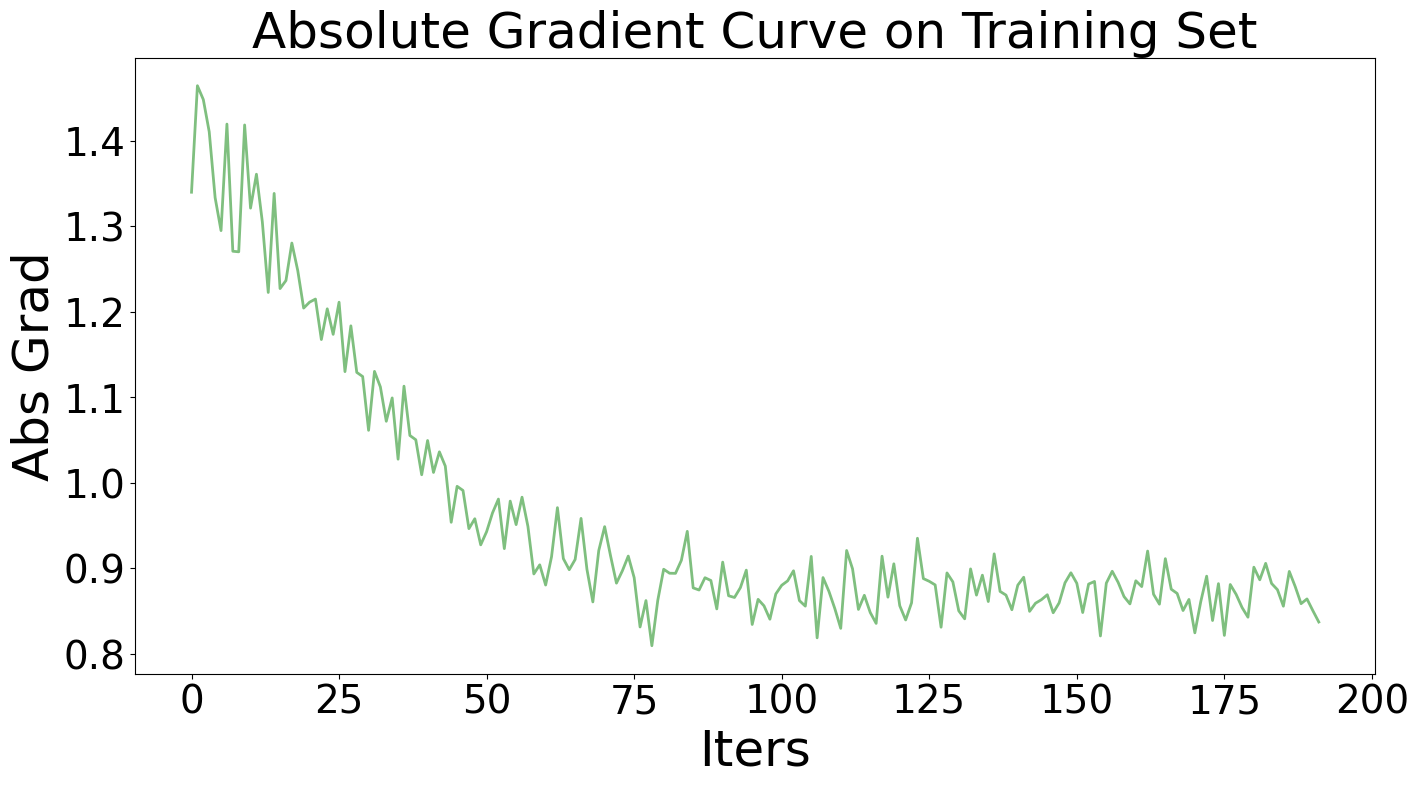

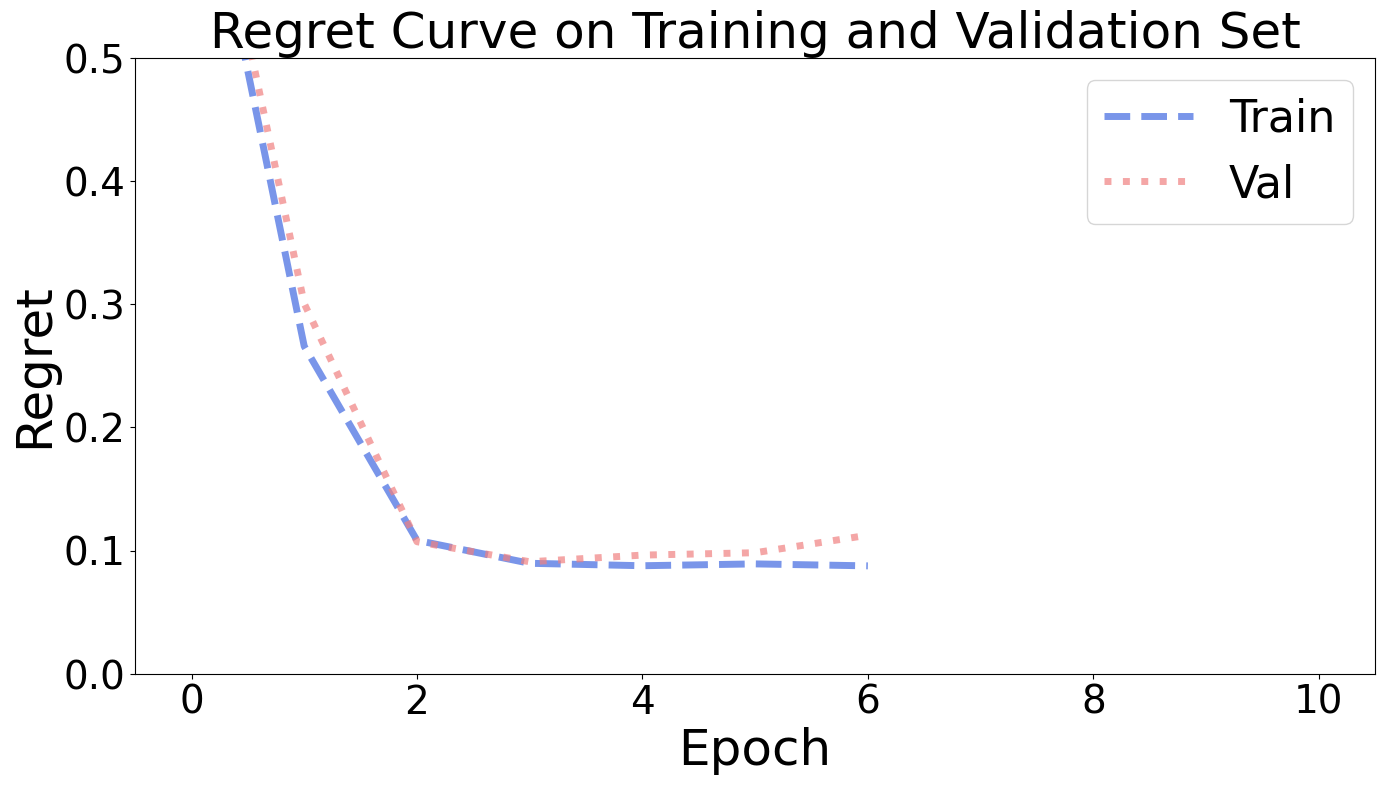

In [27]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method with Cone Check 

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100, check_cone=True)

Num of cores: 1


In [30]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  53.1675%, Val Regret:  53.8933%


Epoch    0, Loss:  -0.6092:  10%|█████▌                                                 | 1/10 [00:06<00:39,  4.37s/it]

Epoch   1, Train Regret:  15.8392%, Val Regret:  16.0713%


Epoch    1, Loss:  -0.8442:  20%|███████████                                            | 2/10 [00:10<00:35,  4.44s/it]

Epoch   2, Train Regret:   8.6034%, Val Regret:  12.4436%


Epoch    2, Loss:  -0.8620:  30%|████████████████▌                                      | 3/10 [00:15<00:31,  4.53s/it]

Epoch   3, Train Regret:   8.9063%, Val Regret:   9.4816%


Epoch    3, Loss:  -0.9042:  40%|██████████████████████                                 | 4/10 [00:19<00:27,  4.51s/it]

Epoch   4, Train Regret:   9.0069%, Val Regret:   9.4258%


Epoch    4, Loss:  -0.7851:  50%|███████████████████████████▌                           | 5/10 [00:24<00:22,  4.52s/it]

Epoch   5, Train Regret:   9.0749%, Val Regret:   9.1884%


Epoch    5, Loss:  -0.9186:  60%|█████████████████████████████████                      | 6/10 [00:28<00:18,  4.53s/it]

Epoch   6, Train Regret:   8.1547%, Val Regret:   9.7283%


Epoch    6, Loss:  -0.7517:  70%|██████████████████████████████████████▌                | 7/10 [00:33<00:13,  4.53s/it]

Epoch   7, Train Regret:   9.0635%, Val Regret:   8.9302%


Epoch    7, Loss:  -0.7757:  80%|████████████████████████████████████████████           | 8/10 [00:37<00:08,  4.49s/it]

Epoch   8, Train Regret:   8.2707%, Val Regret:   9.3979%


Epoch    8, Loss:  -0.7968:  90%|█████████████████████████████████████████████████▌     | 9/10 [00:42<00:04,  4.50s/it]

Epoch   9, Train Regret:   8.5202%, Val Regret:   8.9171%


Epoch    9, Loss:  -0.7859: 100%|██████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.50s/it]


Epoch   9, Train Regret:   8.6649%, Val Regret:   9.6280%

Evaluation:
Test Regret: 9.7385%
Training Elapsed Time: 18.52 Sec


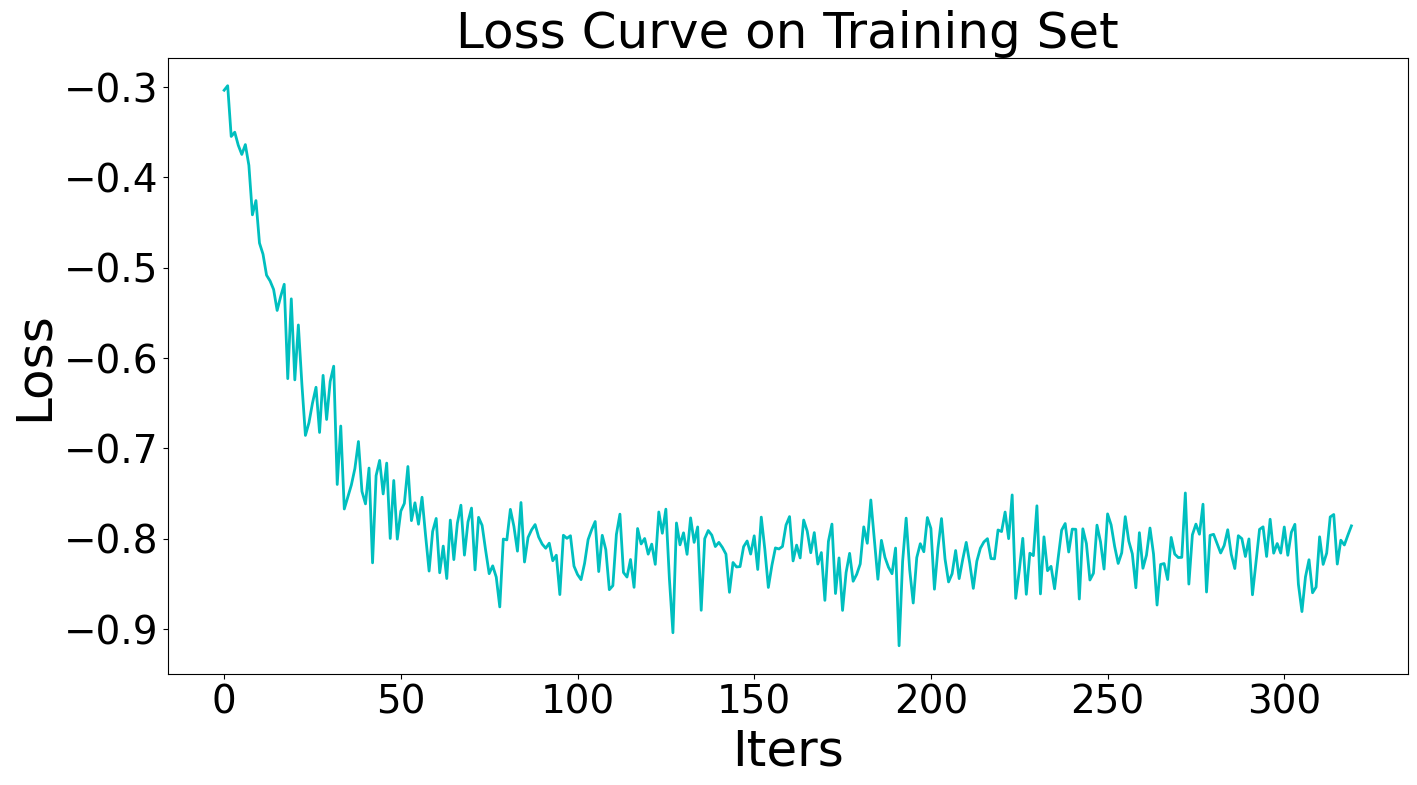

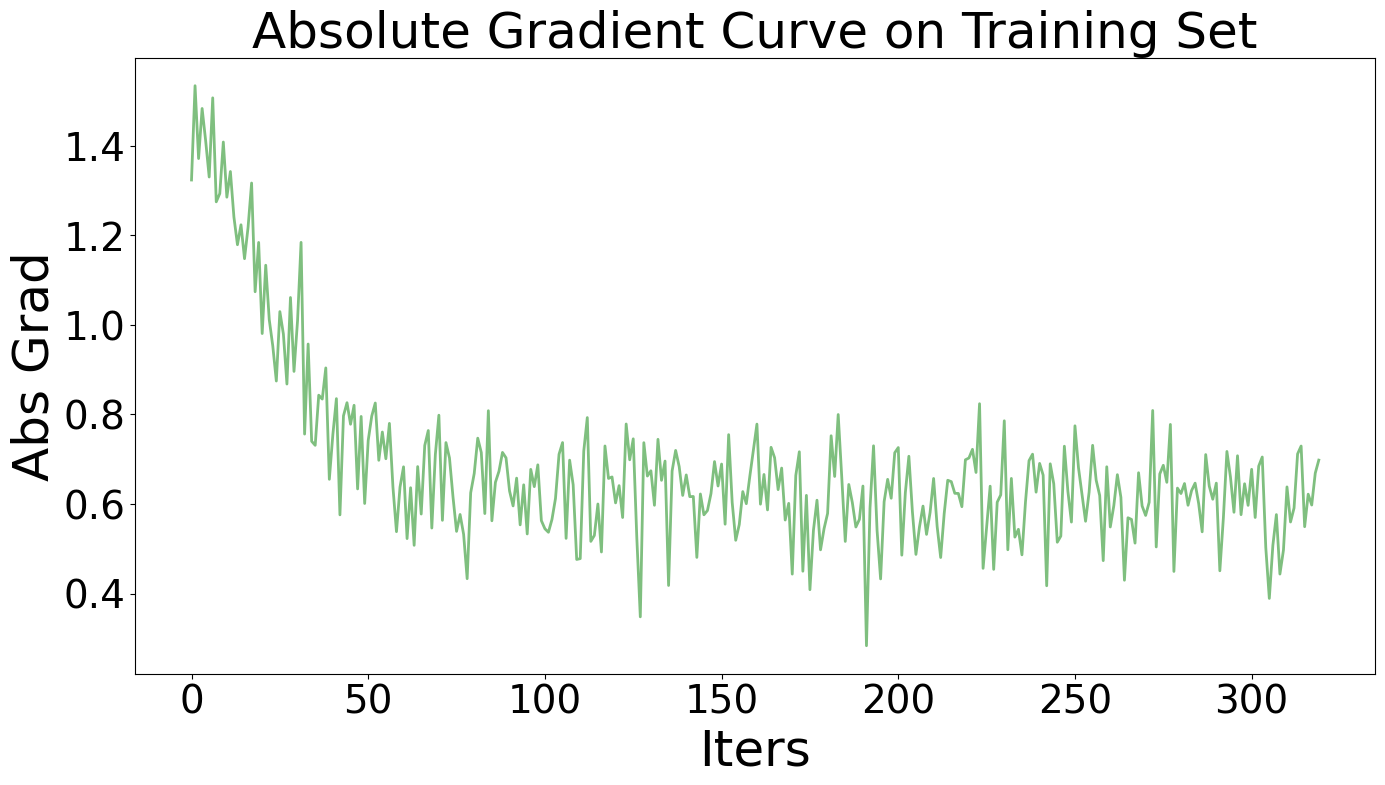

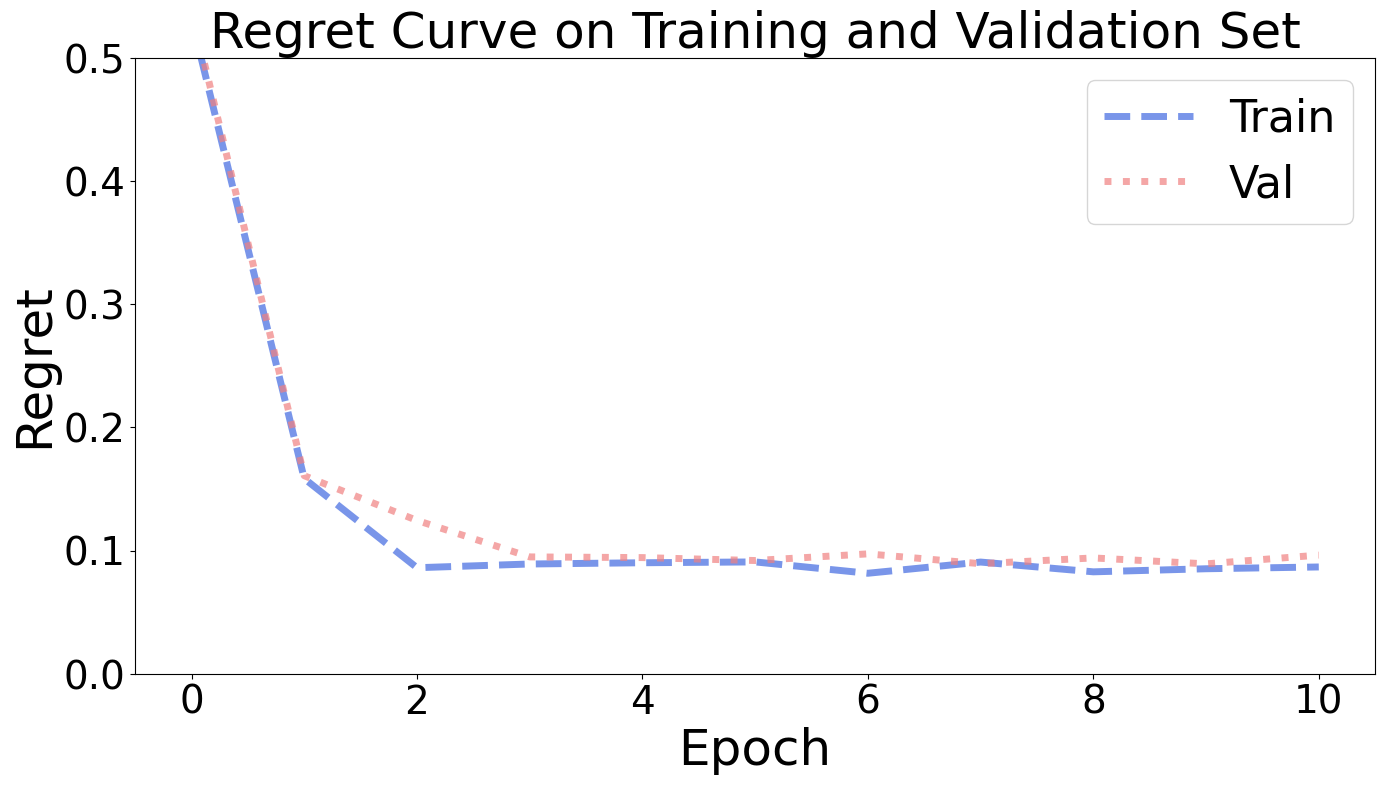

In [31]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

Num of cores: 1


In [34]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  64.9930%, Val Regret:  68.2556%


Epoch    0, Loss:  -0.4946:  10%|█████▌                                                 | 1/10 [00:04<00:25,  2.81s/it]

Epoch   1, Train Regret:  16.9259%, Val Regret:  18.6879%


Epoch    1, Loss:  -0.6351:  20%|███████████                                            | 2/10 [00:07<00:22,  2.81s/it]

Epoch   2, Train Regret:   9.3136%, Val Regret:  10.5680%


Epoch    2, Loss:  -0.7852:  30%|████████████████▌                                      | 3/10 [00:09<00:19,  2.78s/it]

Epoch   3, Train Regret:   8.5982%, Val Regret:  10.5731%


Epoch    3, Loss:  -0.7626:  40%|██████████████████████                                 | 4/10 [00:12<00:16,  2.75s/it]

Epoch   4, Train Regret:   8.8133%, Val Regret:  11.2653%


Epoch    4, Loss:  -0.7085:  50%|███████████████████████████▌                           | 5/10 [00:15<00:15,  3.07s/it]


Epoch   5, Train Regret:   8.5935%, Val Regret:  11.0138%

Early Stop!

Evaluation:
Test Regret: 9.8749%
Training Elapsed Time: 0.49 Sec


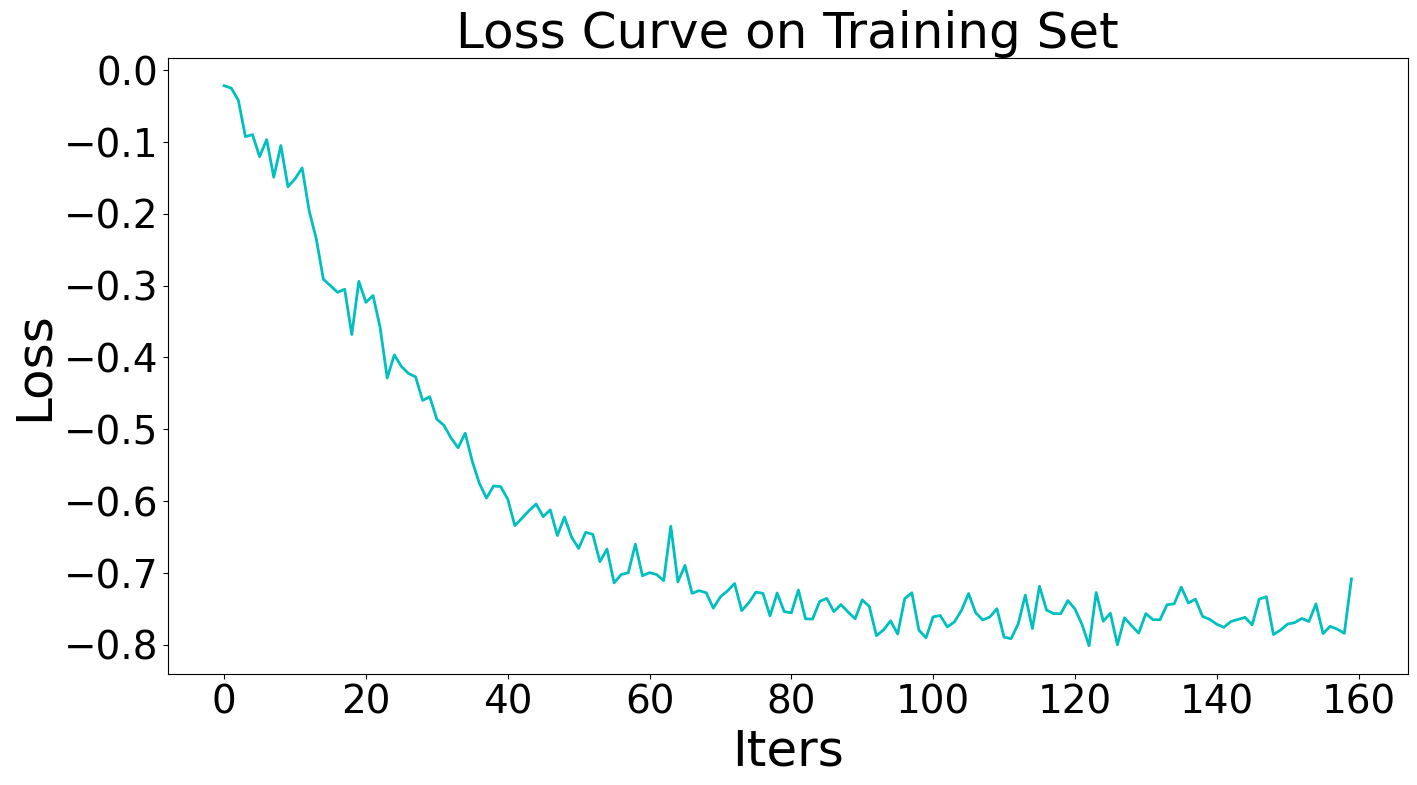

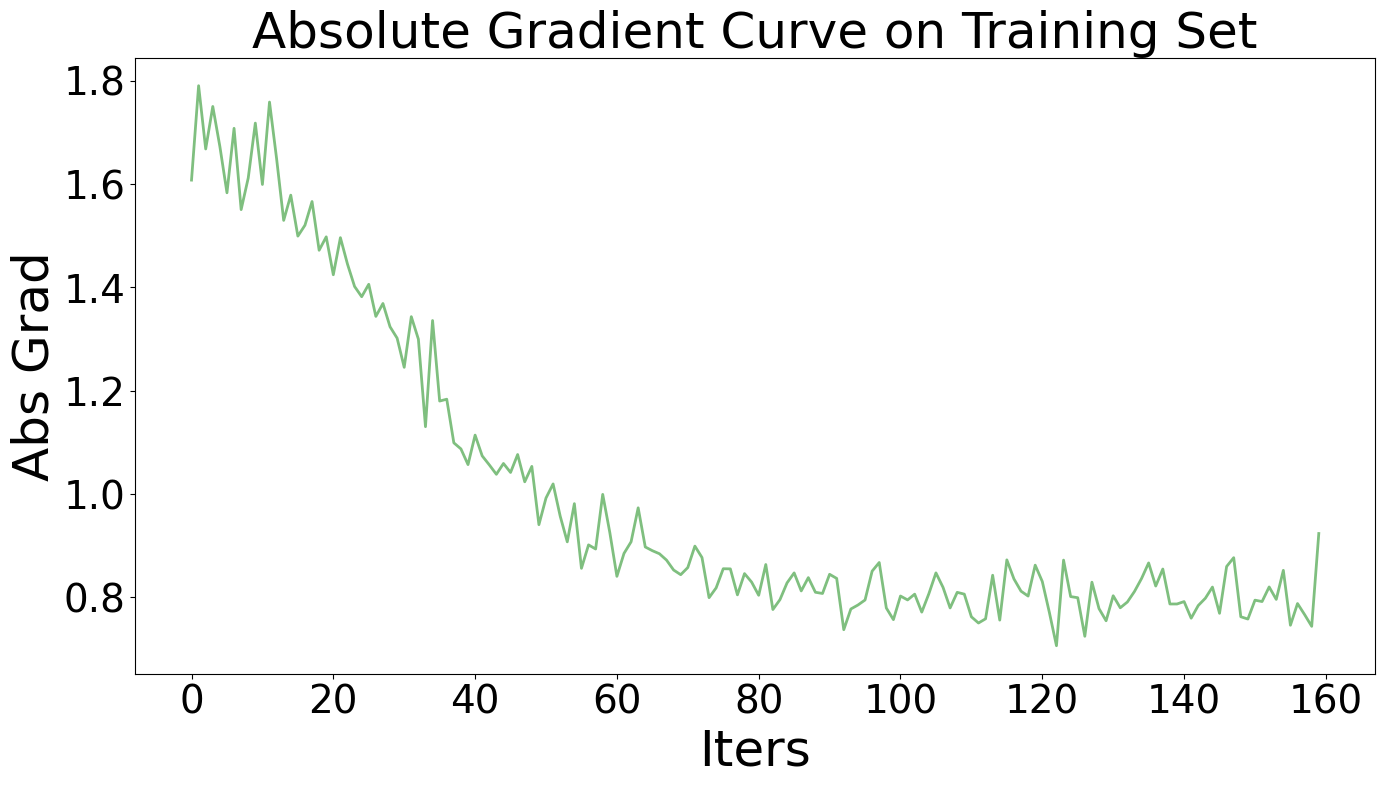

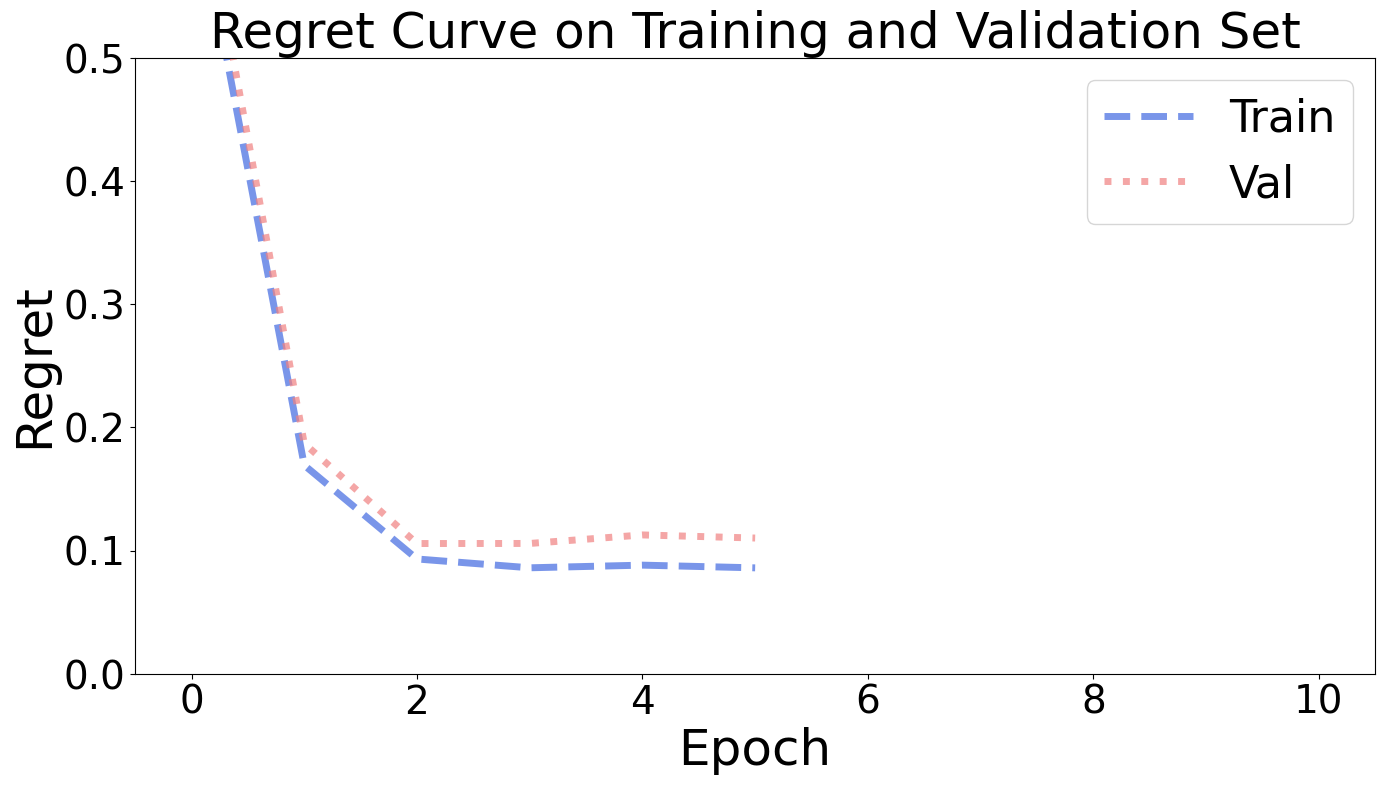

In [35]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method with Cone Check 

In [36]:
# init model
reg = LinearRegression()

In [37]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel, check_cone=True)

Num of cores: 1


In [38]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  67.8297%, Val Regret:  76.5275%


Epoch    0, Loss:  -0.5595:  10%|█████▌                                                 | 1/10 [00:06<00:40,  4.49s/it]

Epoch   1, Train Regret:  19.1210%, Val Regret:  22.3851%


Epoch    1, Loss:  -0.6476:  20%|███████████                                            | 2/10 [00:10<00:35,  4.46s/it]

Epoch   2, Train Regret:  10.4316%, Val Regret:  12.1369%


Epoch    2, Loss:  -0.8695:  30%|████████████████▌                                      | 3/10 [00:15<00:31,  4.53s/it]

Epoch   3, Train Regret:   9.5236%, Val Regret:  10.1928%


Epoch    3, Loss:  -0.8371:  40%|██████████████████████                                 | 4/10 [00:20<00:27,  4.58s/it]

Epoch   4, Train Regret:   8.5917%, Val Regret:   9.2843%


Epoch    4, Loss:  -0.7088:  50%|███████████████████████████▌                           | 5/10 [00:25<00:24,  4.83s/it]

Epoch   5, Train Regret:   8.5913%, Val Regret:   9.5117%


Epoch    5, Loss:  -0.9546:  60%|█████████████████████████████████                      | 6/10 [00:29<00:19,  4.82s/it]

Epoch   6, Train Regret:   8.4338%, Val Regret:   9.2117%


Epoch    6, Loss:  -0.8270:  70%|██████████████████████████████████████▌                | 7/10 [00:34<00:14,  4.67s/it]

Epoch   7, Train Regret:   8.5065%, Val Regret:   9.0458%


Epoch    7, Loss:  -0.7584:  80%|████████████████████████████████████████████           | 8/10 [00:38<00:09,  4.59s/it]

Epoch   8, Train Regret:   8.7474%, Val Regret:   9.5537%


Epoch    8, Loss:  -0.8321:  90%|█████████████████████████████████████████████████▌     | 9/10 [00:43<00:04,  4.56s/it]

Epoch   9, Train Regret:   8.6130%, Val Regret:   8.1179%


Epoch    9, Loss:  -0.8679: 100%|██████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.60s/it]


Epoch   9, Train Regret:   8.9565%, Val Regret:   9.9914%

Evaluation:
Test Regret: 9.6837%
Training Elapsed Time: 18.80 Sec


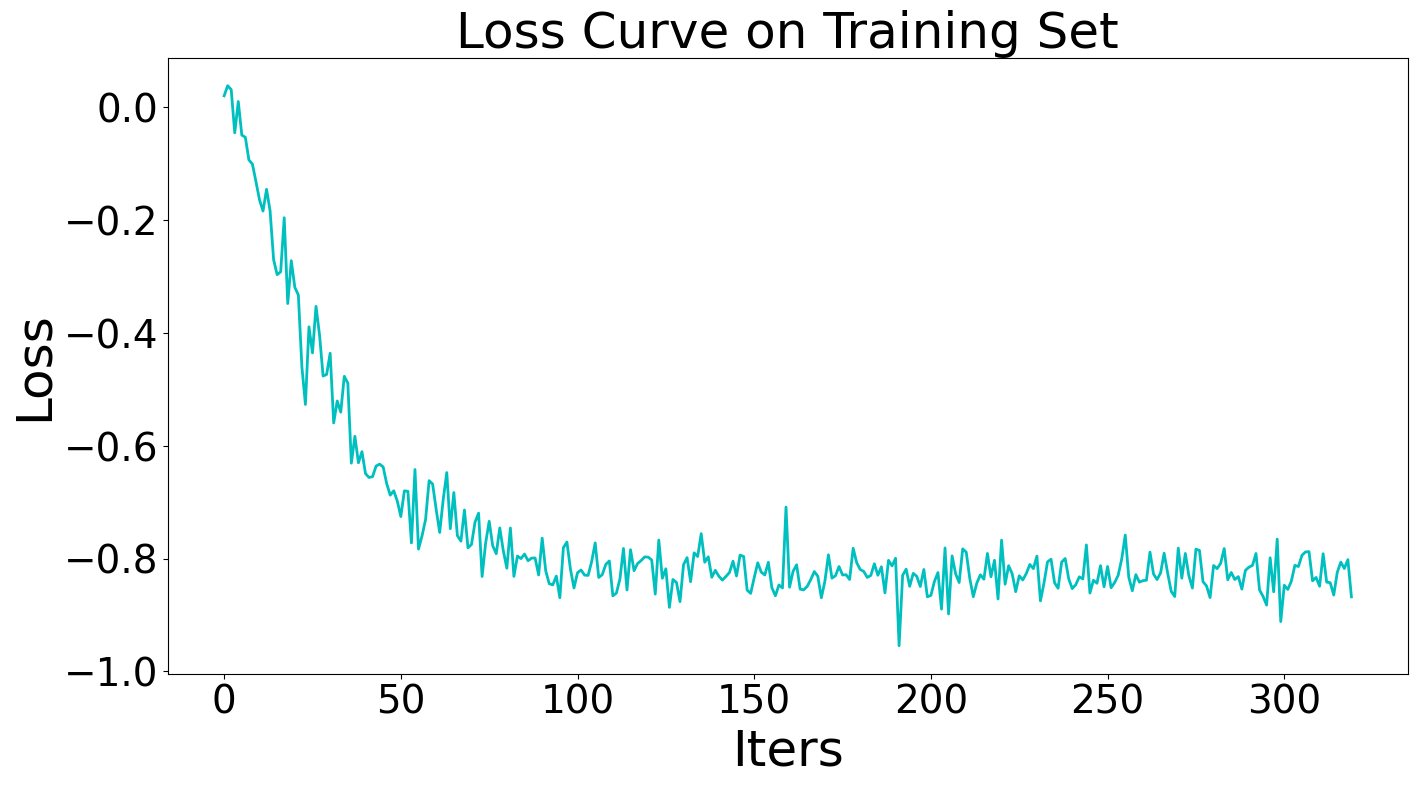

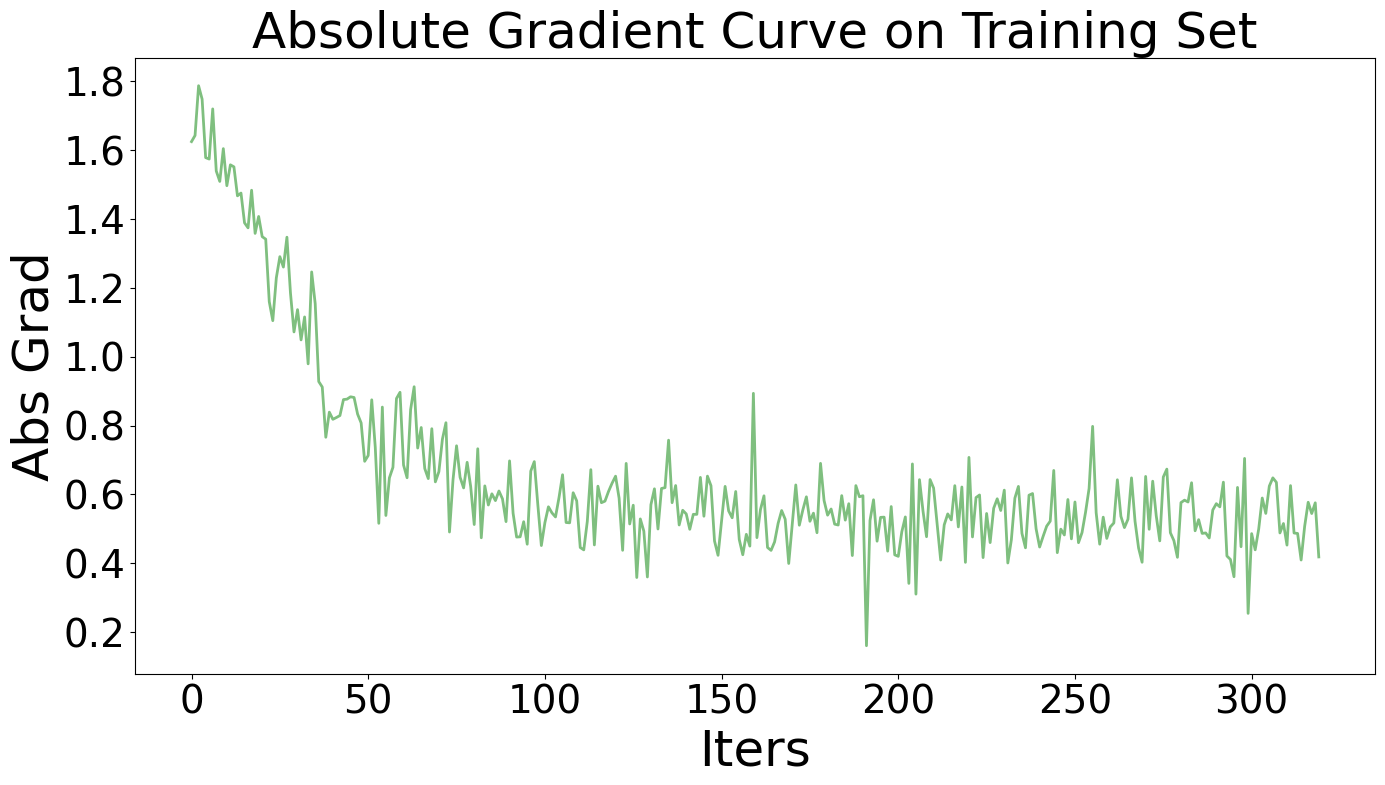

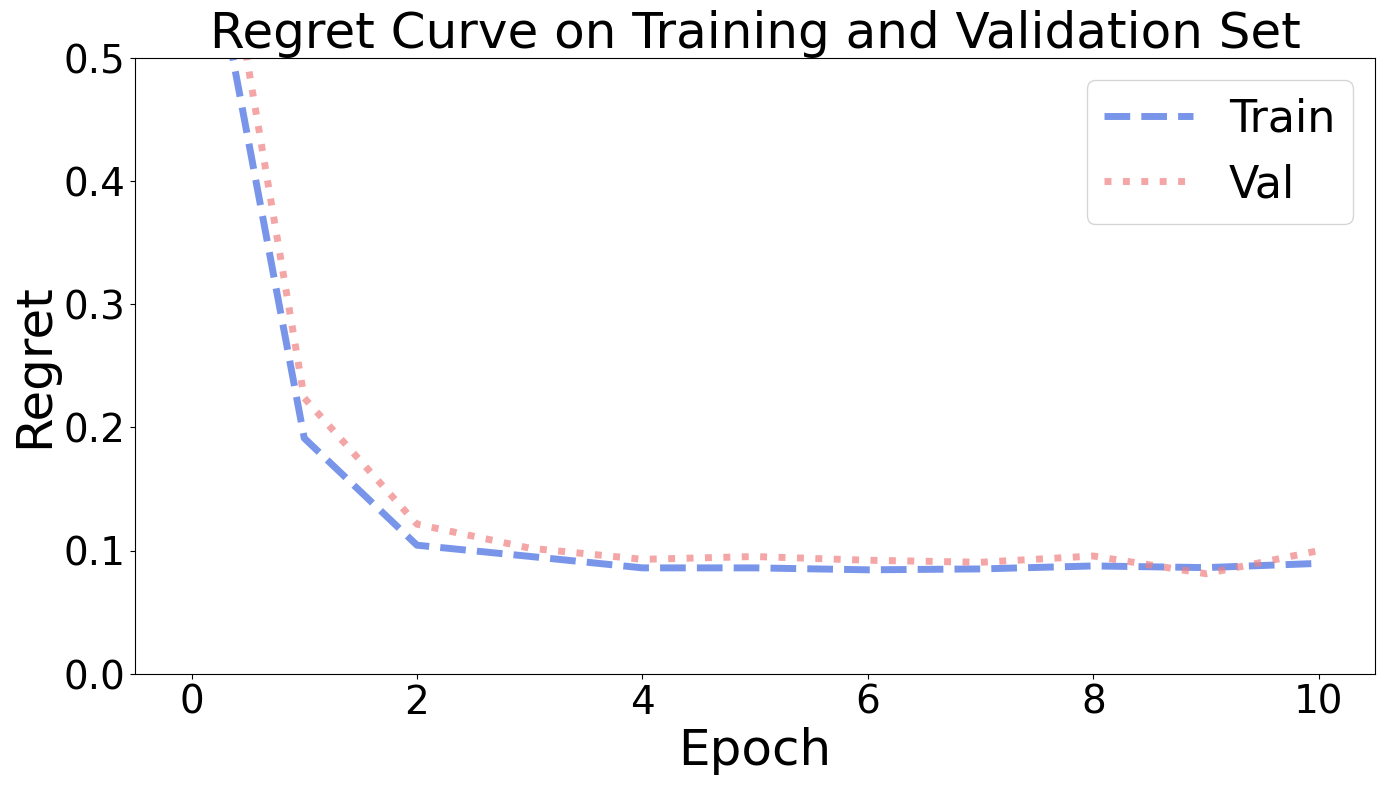

In [39]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL 

In [40]:
# init model
reg = LinearRegression()

In [41]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=8)

def forwardPFY(data, reg, loss_func, grad_log):
    # unzip data
    x, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [42]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardPFY, pfy, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  60.5412%, Val Regret:  64.2153%


Epoch    0, Loss:  12.0000:  10%|█████▌                                                 | 1/10 [00:06<00:38,  4.33s/it]

Epoch   1, Train Regret:  13.7498%, Val Regret:  12.6229%


Epoch    1, Loss:   7.5000:  20%|███████████                                            | 2/10 [00:10<00:35,  4.38s/it]

Epoch   2, Train Regret:   7.9901%, Val Regret:   7.1784%


Epoch    2, Loss:   5.5000:  30%|████████████████▌                                      | 3/10 [00:14<00:30,  4.35s/it]

Epoch   3, Train Regret:   7.6534%, Val Regret:   7.2435%


Epoch    3, Loss:   9.5000:  40%|██████████████████████                                 | 4/10 [00:18<00:25,  4.31s/it]

Epoch   4, Train Regret:   7.1869%, Val Regret:   9.1765%


Epoch    4, Loss:   9.5000:  50%|███████████████████████████▌                           | 5/10 [00:23<00:21,  4.25s/it]

Epoch   5, Train Regret:   7.2364%, Val Regret:   6.9460%


Epoch    5, Loss:   8.0000:  60%|█████████████████████████████████                      | 6/10 [00:27<00:16,  4.23s/it]

Epoch   6, Train Regret:   6.9668%, Val Regret:   8.2742%


Epoch    6, Loss:   6.5000:  70%|██████████████████████████████████████▌                | 7/10 [00:31<00:12,  4.17s/it]

Epoch   7, Train Regret:   7.1438%, Val Regret:   7.5601%


Epoch    7, Loss:   8.7500:  80%|████████████████████████████████████████████           | 8/10 [00:35<00:08,  4.19s/it]

Epoch   8, Train Regret:   7.2092%, Val Regret:   6.4186%


Epoch    8, Loss:   6.7500:  90%|█████████████████████████████████████████████████▌     | 9/10 [00:39<00:04,  4.21s/it]

Epoch   9, Train Regret:   7.0328%, Val Regret:   8.7899%


Epoch    9, Loss:   5.0000: 100%|██████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.22s/it]


Epoch   9, Train Regret:   6.9811%, Val Regret:   8.4744%

Evaluation:
Test Regret: 7.4457%
Training Elapsed Time: 16.24 Sec


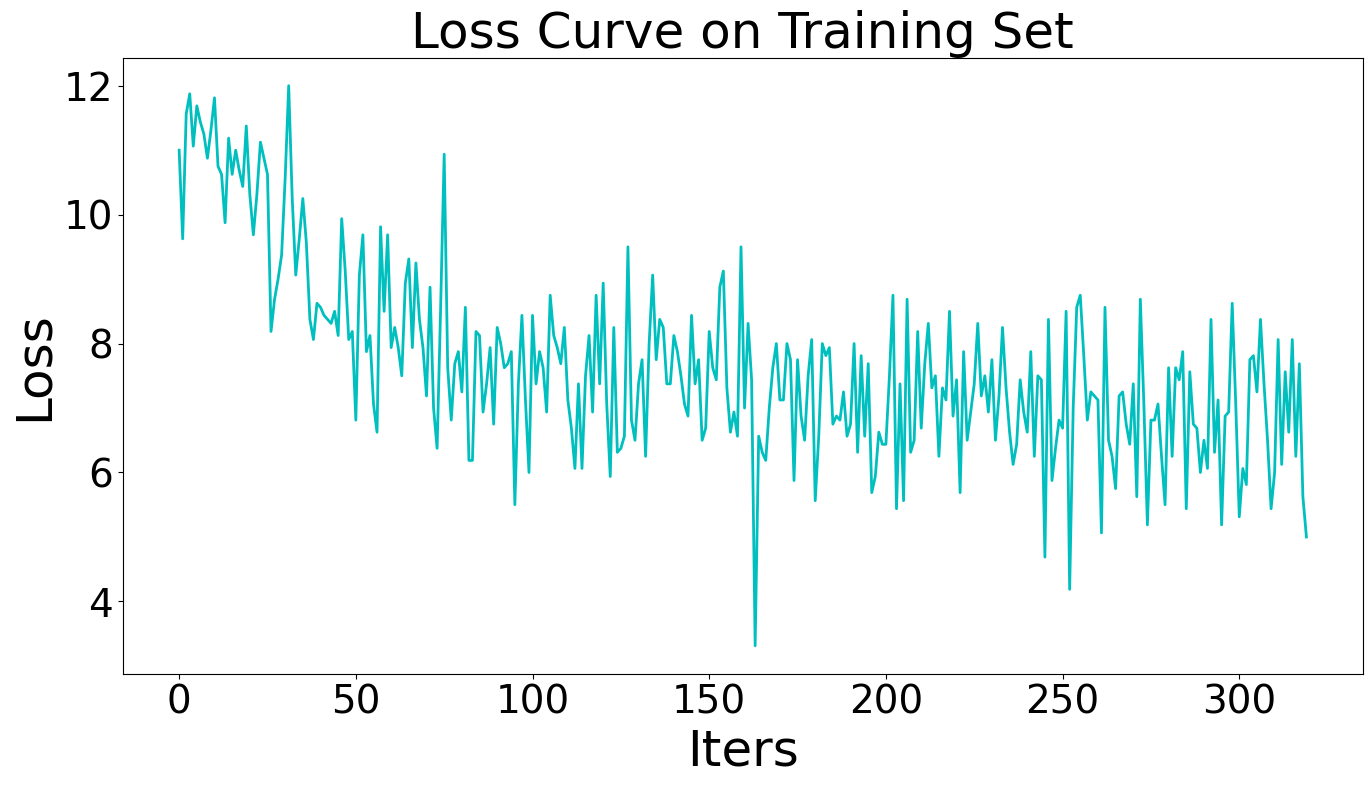

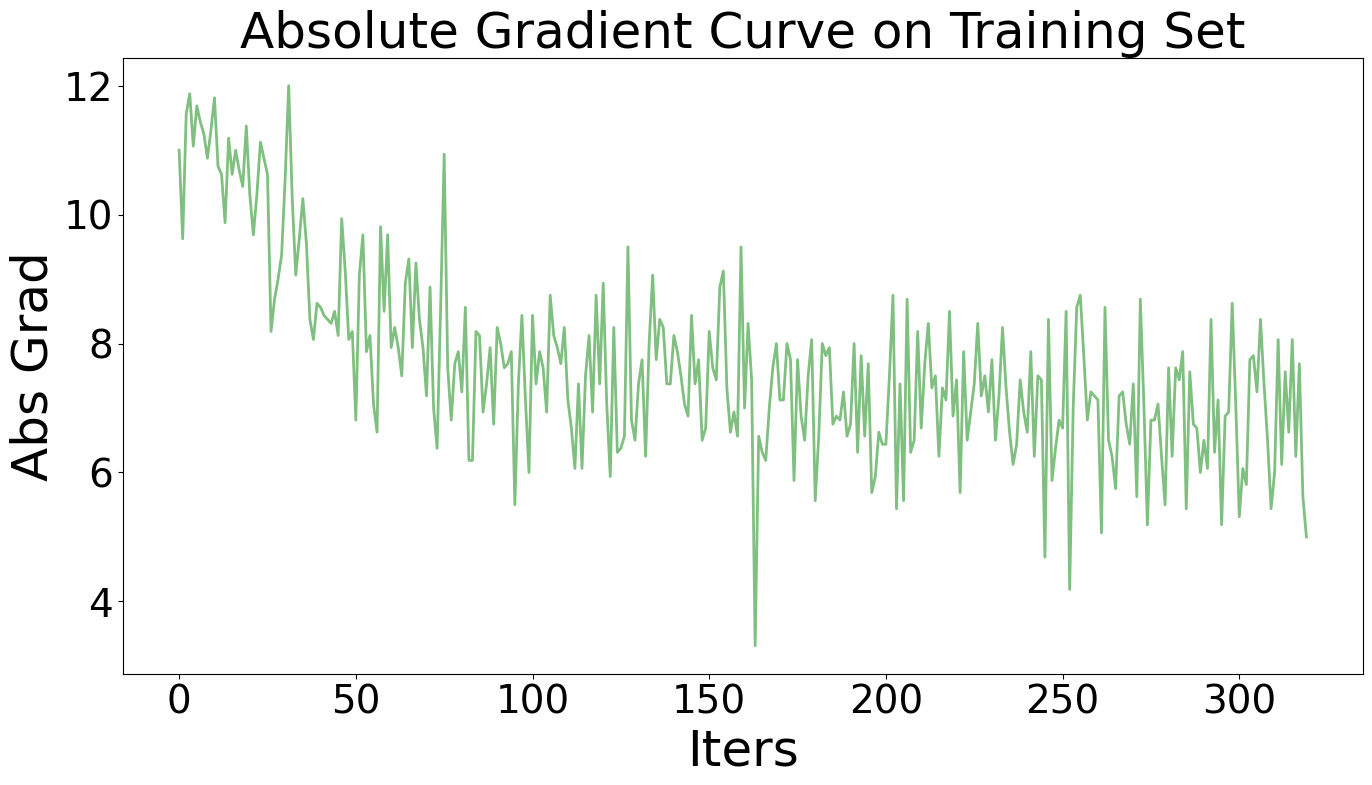

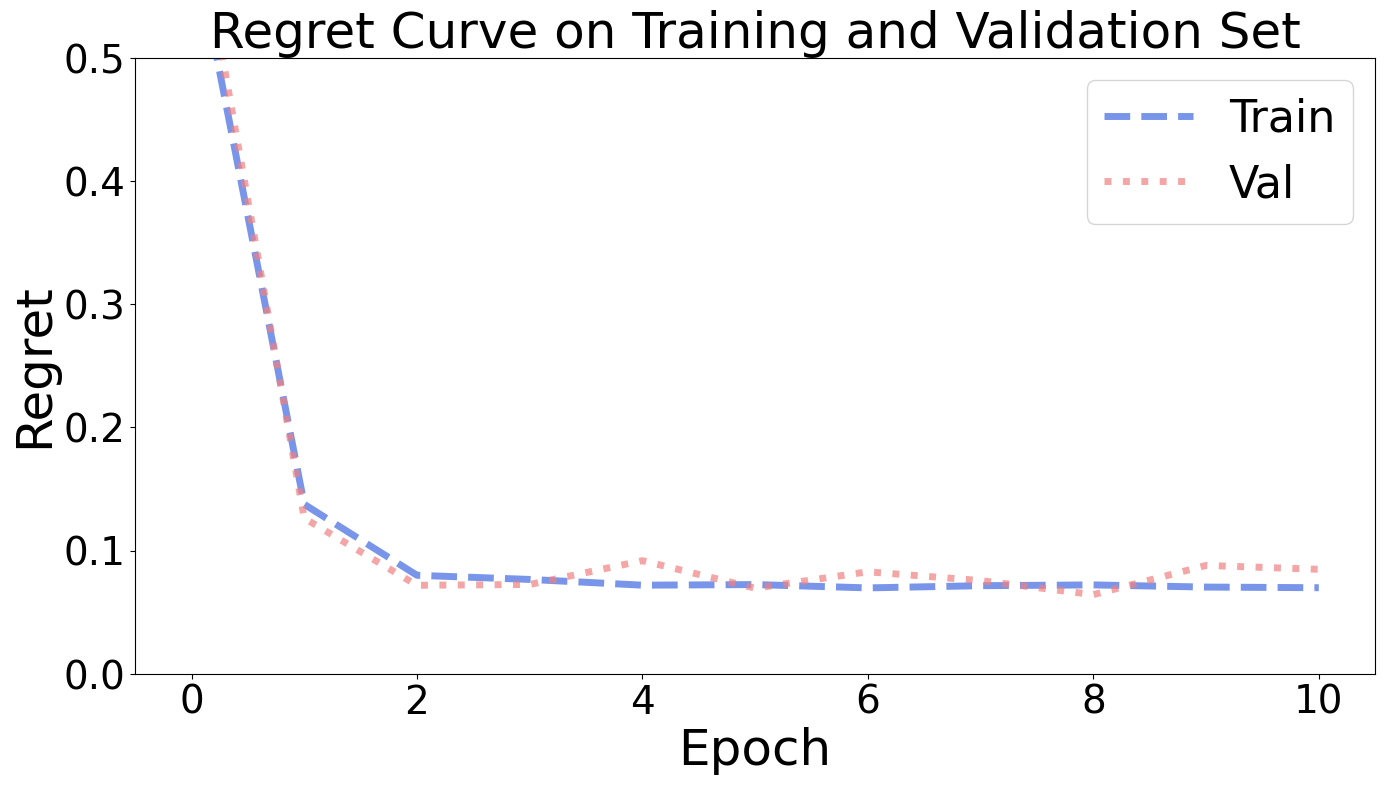

In [43]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NCE 

In [44]:
# init model
reg = LinearRegression()

In [45]:
from pyepo.func import NCE
# init nce loss
nce = NCE(optmodel, processes=8, solve_ratio=0.05, dataset=dataset_train_cost)

def forwardNCE(data, reg, loss_func, grad_log):
    # unzip data
    x, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [46]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardNCE, nce, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  60.5412%, Val Regret:  64.2153%


Epoch    0, Loss:  -2.5546:  10%|█████▌                                                 | 1/10 [00:04<00:26,  2.91s/it]

Epoch   1, Train Regret:  19.8914%, Val Regret:  20.9855%


Epoch    1, Loss:  -6.9351:  20%|███████████                                            | 2/10 [00:07<00:22,  2.80s/it]

Epoch   2, Train Regret:  12.6815%, Val Regret:  10.8714%


Epoch    2, Loss: -10.2879:  30%|████████████████▌                                      | 3/10 [00:09<00:19,  2.73s/it]

Epoch   3, Train Regret:  11.3661%, Val Regret:  11.4400%


Epoch    3, Loss: -11.6128:  40%|██████████████████████                                 | 4/10 [00:12<00:16,  2.72s/it]

Epoch   4, Train Regret:  10.6116%, Val Regret:  11.4611%


Epoch    4, Loss: -11.1938:  50%|███████████████████████████▌                           | 5/10 [00:15<00:15,  3.02s/it]


Epoch   5, Train Regret:  10.7581%, Val Regret:  11.1127%

Early Stop!

Evaluation:
Test Regret: 13.1223%
Training Elapsed Time: 0.89 Sec


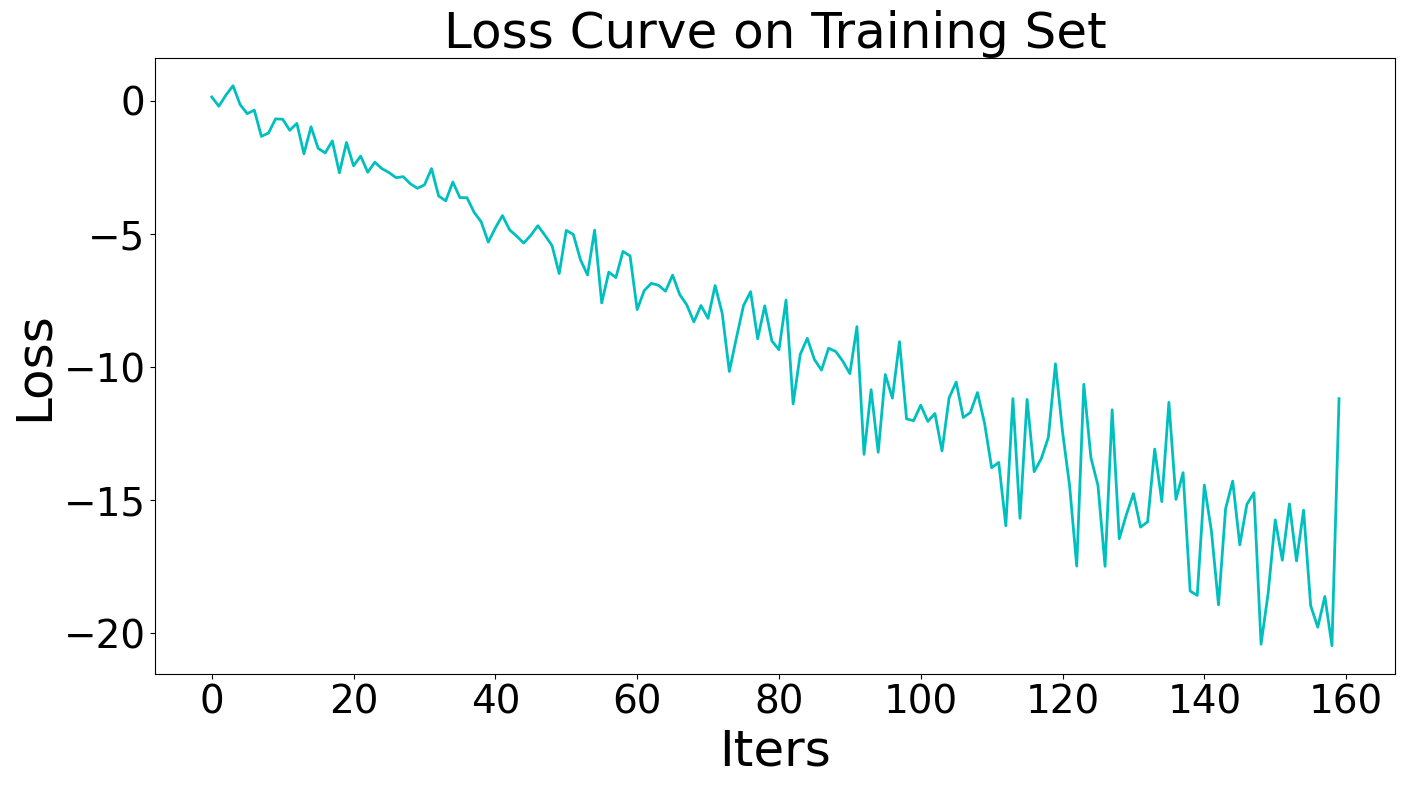

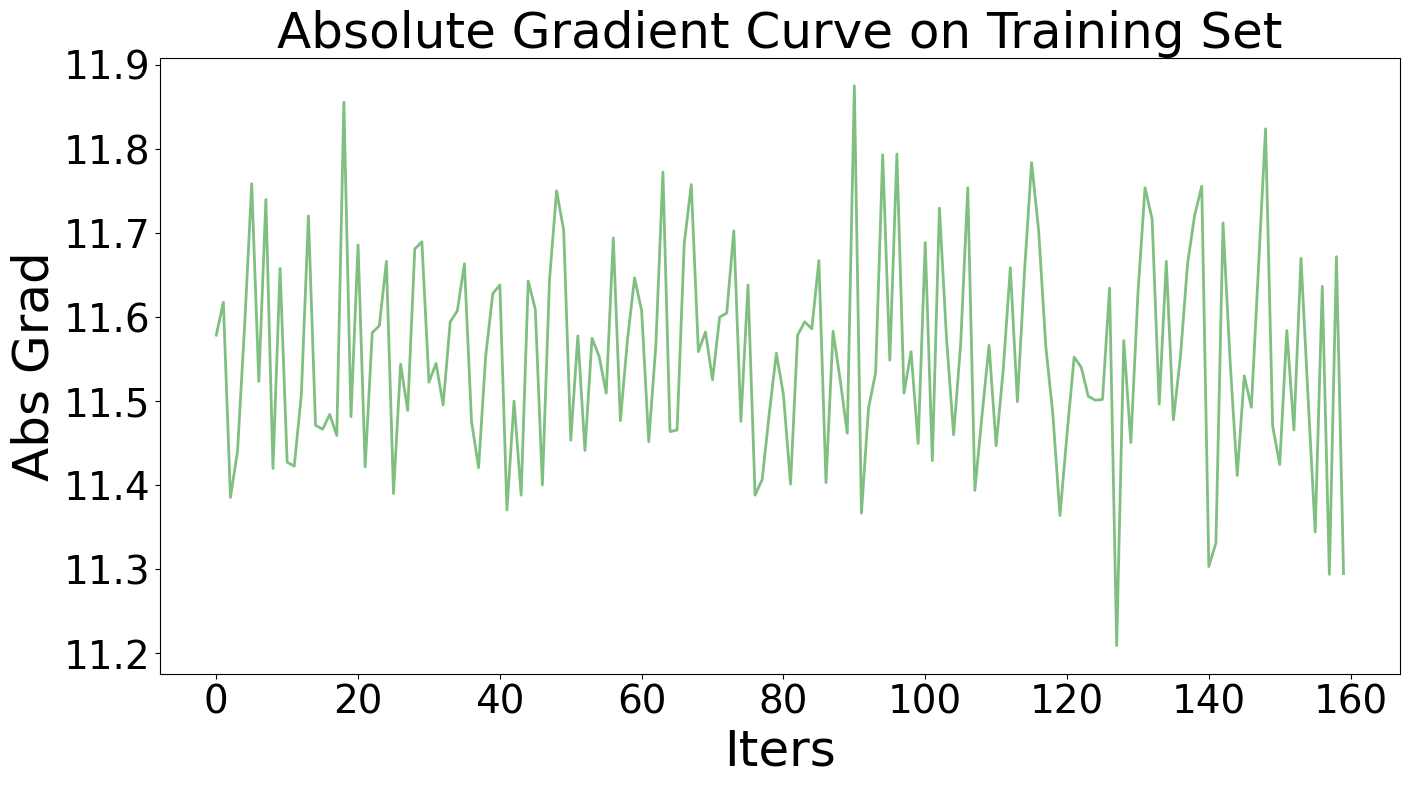

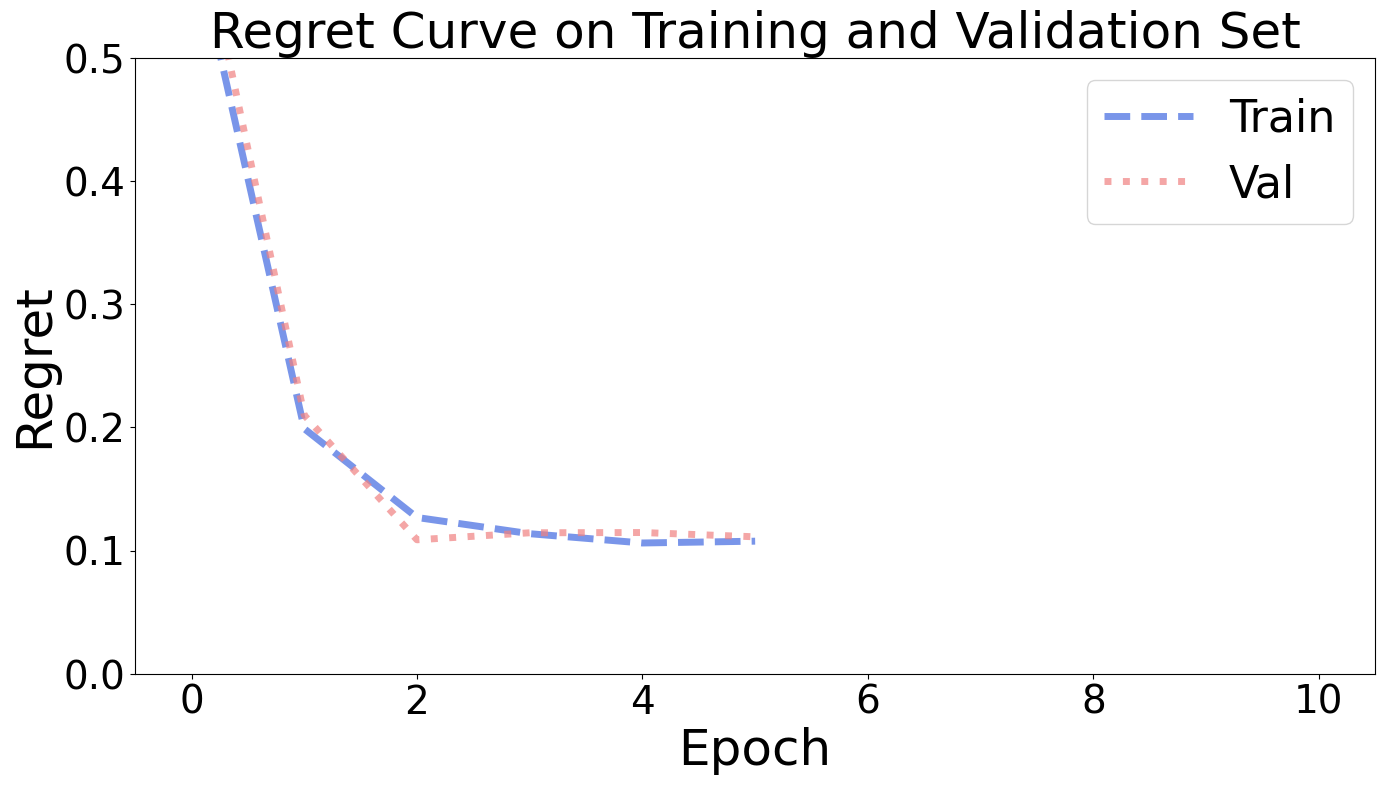

In [47]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)